In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

### Functions used in this code
import age_functions as afunc
import extinction as extinct
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons

### Stuff Writtten by A Really Cool Professor
from dlnpyutils import utils as dln

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

# Import Data

In [2]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])


harris_dist = [4.5,4.4,6.4,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,9.6,8.9,
               4.9,8.6,19.3,17.4,16.0,8.9,30.5,9.5,5.9,10.4,9.9,2.3,11.6,7.7,3.0,10.9,8.1,8.7,4.0,7.4,23.2,5.8,
               8.2,7.1,10.9,5.2]
harris_ebv = [0.04,0.28,0.33,0.19,0.02,0.10,0.38,0.10,0.34,0.01,0.35,0.03,0.02,0.15,0.08,0.05,0.25,0.01,0.02,0.02,
              0.22,0.03,0.24,0.05,0.02,0.01,0.00,0.36,0.01,0.36,0.54,0.54,0.37,0.18,0.47,0.48,0.76,0.53,0.40,0.05,
              0.04,0.77,0.03,1.46,1.24,1.76,1.17,0.12]

gcs['harris_dist'] = np.zeros(len(gcs))
gcs['harris_ebv'] = -9999.0*np.ones(len(gcs))

for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs['harris_dist'][clus] = harris_dist[i]
    gcs['harris_ebv'][clus] = harris_ebv[i]

In [3]:
### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)

bad:  24
bad:  27
bad:  37


In [4]:
### Find Clusters with more than 10 stars

good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [5]:
good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

In [6]:
### PARSEC

# 12 Gyr
parsec12e9 = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec12e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')

parsec12e9 = Table.from_pandas(parsec12e9)
parsec12e9 = parsec12e9[np.where(parsec12e9['label']==3)]

# 5 Gyr
parsec5e9 = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec5e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')

parsec5e9 = Table.from_pandas(parsec5e9)
parsec5e9 = parsec5e9[np.where(parsec5e9['label']==3)]

# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

<font size='15'>
    <b>
        Color Color
    </b>
</font>

In [7]:
p12e9_2_2 = parsec12e9[np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],-2.2)[0])]
p12e9_1_0 = parsec12e9[np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],-1.0)[0])]
p12e9_0_0 = parsec12e9[np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],0.0)[0])]

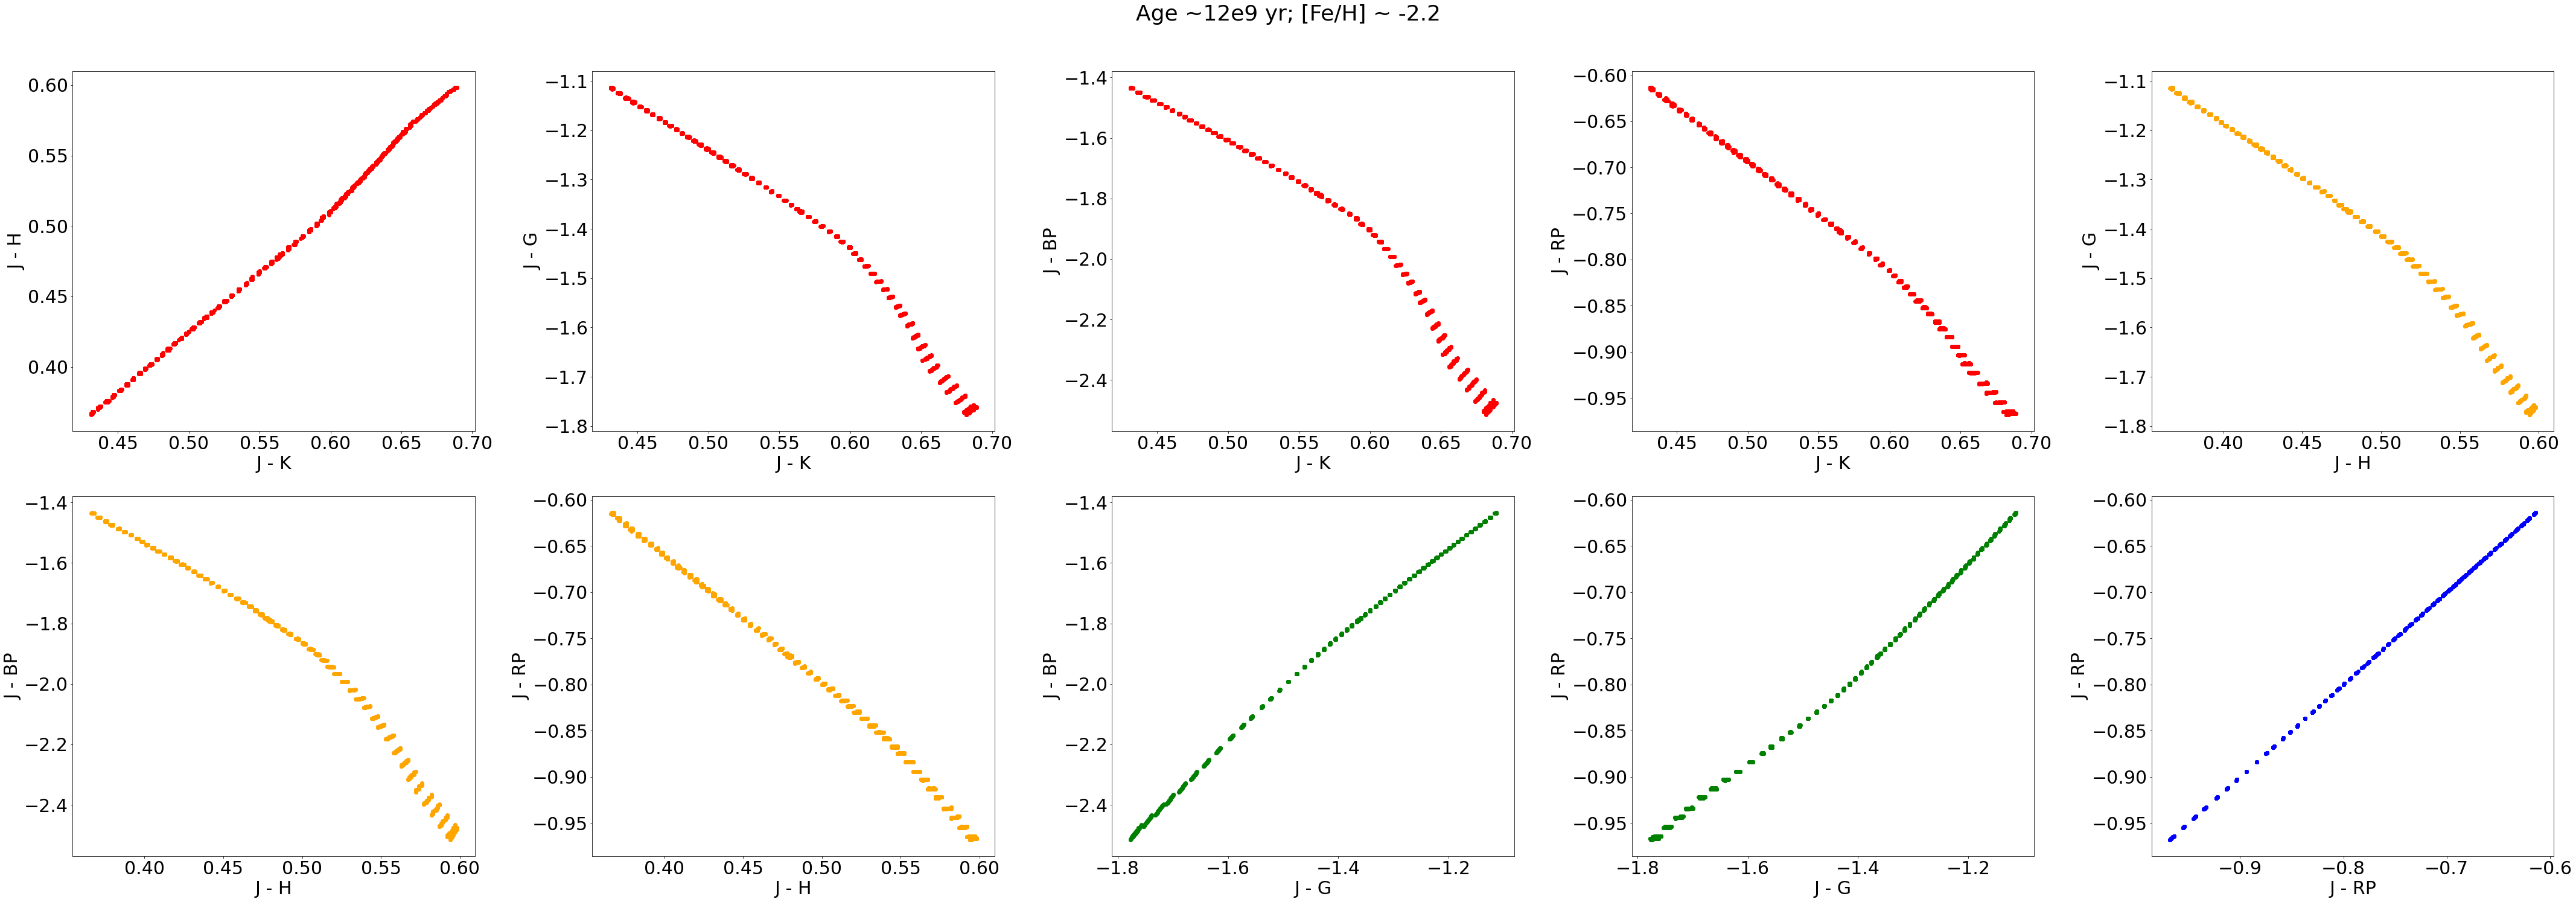

In [8]:
####################################
### Age ~12e9 yr; [Fe/H] ~ -2.2 ###
####################################

xcol22 = [p12e9_2_2['Jmag']-p12e9_2_2['Ksmag'],p12e9_2_2['Jmag']-p12e9_2_2['Ksmag'],
          p12e9_2_2['Jmag']-p12e9_2_2['Ksmag'],p12e9_2_2['Jmag']-p12e9_2_2['Ksmag'],
          p12e9_2_2['Jmag']-p12e9_2_2['Hmag'],p12e9_2_2['Jmag']-p12e9_2_2['Hmag'],
          p12e9_2_2['Jmag']-p12e9_2_2['Hmag'],p12e9_2_2['Jmag']-p12e9_2_2['Gmag'],
          p12e9_2_2['Jmag']-p12e9_2_2['Gmag'],p12e9_2_2['Jmag']-p12e9_2_2['G_RPmag']]

ycol22 = [p12e9_2_2['Jmag']-p12e9_2_2['Hmag'],p12e9_2_2['Jmag']-p12e9_2_2['Gmag'],
          p12e9_2_2['Jmag']-p12e9_2_2['G_BPmag'],p12e9_2_2['Jmag']-p12e9_2_2['G_RPmag'],
          p12e9_2_2['Jmag']-p12e9_2_2['Gmag'],p12e9_2_2['Jmag']-p12e9_2_2['G_BPmag'],
          p12e9_2_2['Jmag']-p12e9_2_2['G_RPmag'],p12e9_2_2['Jmag']-p12e9_2_2['G_BPmag'],
          p12e9_2_2['Jmag']-p12e9_2_2['G_RPmag'],p12e9_2_2['Jmag']-p12e9_2_2['G_RPmag']]

xcol22_lab = ['J - K','J - K','J - K','J - K','J - H','J - H','J - H','J - G','J - G','J - RP']

ycol22_lab = ['J - H','J - G','J - BP','J - RP','J - G','J - BP','J - RP','J - BP','J - RP','J - RP']

colors = ['r','r','r','r','orange','orange','orange','g','g','b']

fig,ax = plt.subplots(2,5,figsize=[60,20])
for i, ax in enumerate(ax.ravel()):
    ax.scatter(xcol22[i],ycol22[i],c=colors[i])
    ax.set_xlabel(xcol22_lab[i])
    ax.set_ylabel(ycol22_lab[i])
plt.tight_layout()
plt.suptitle('Age ~12e9 yr; [Fe/H] ~ -2.2',y=1.05)
plt.show()

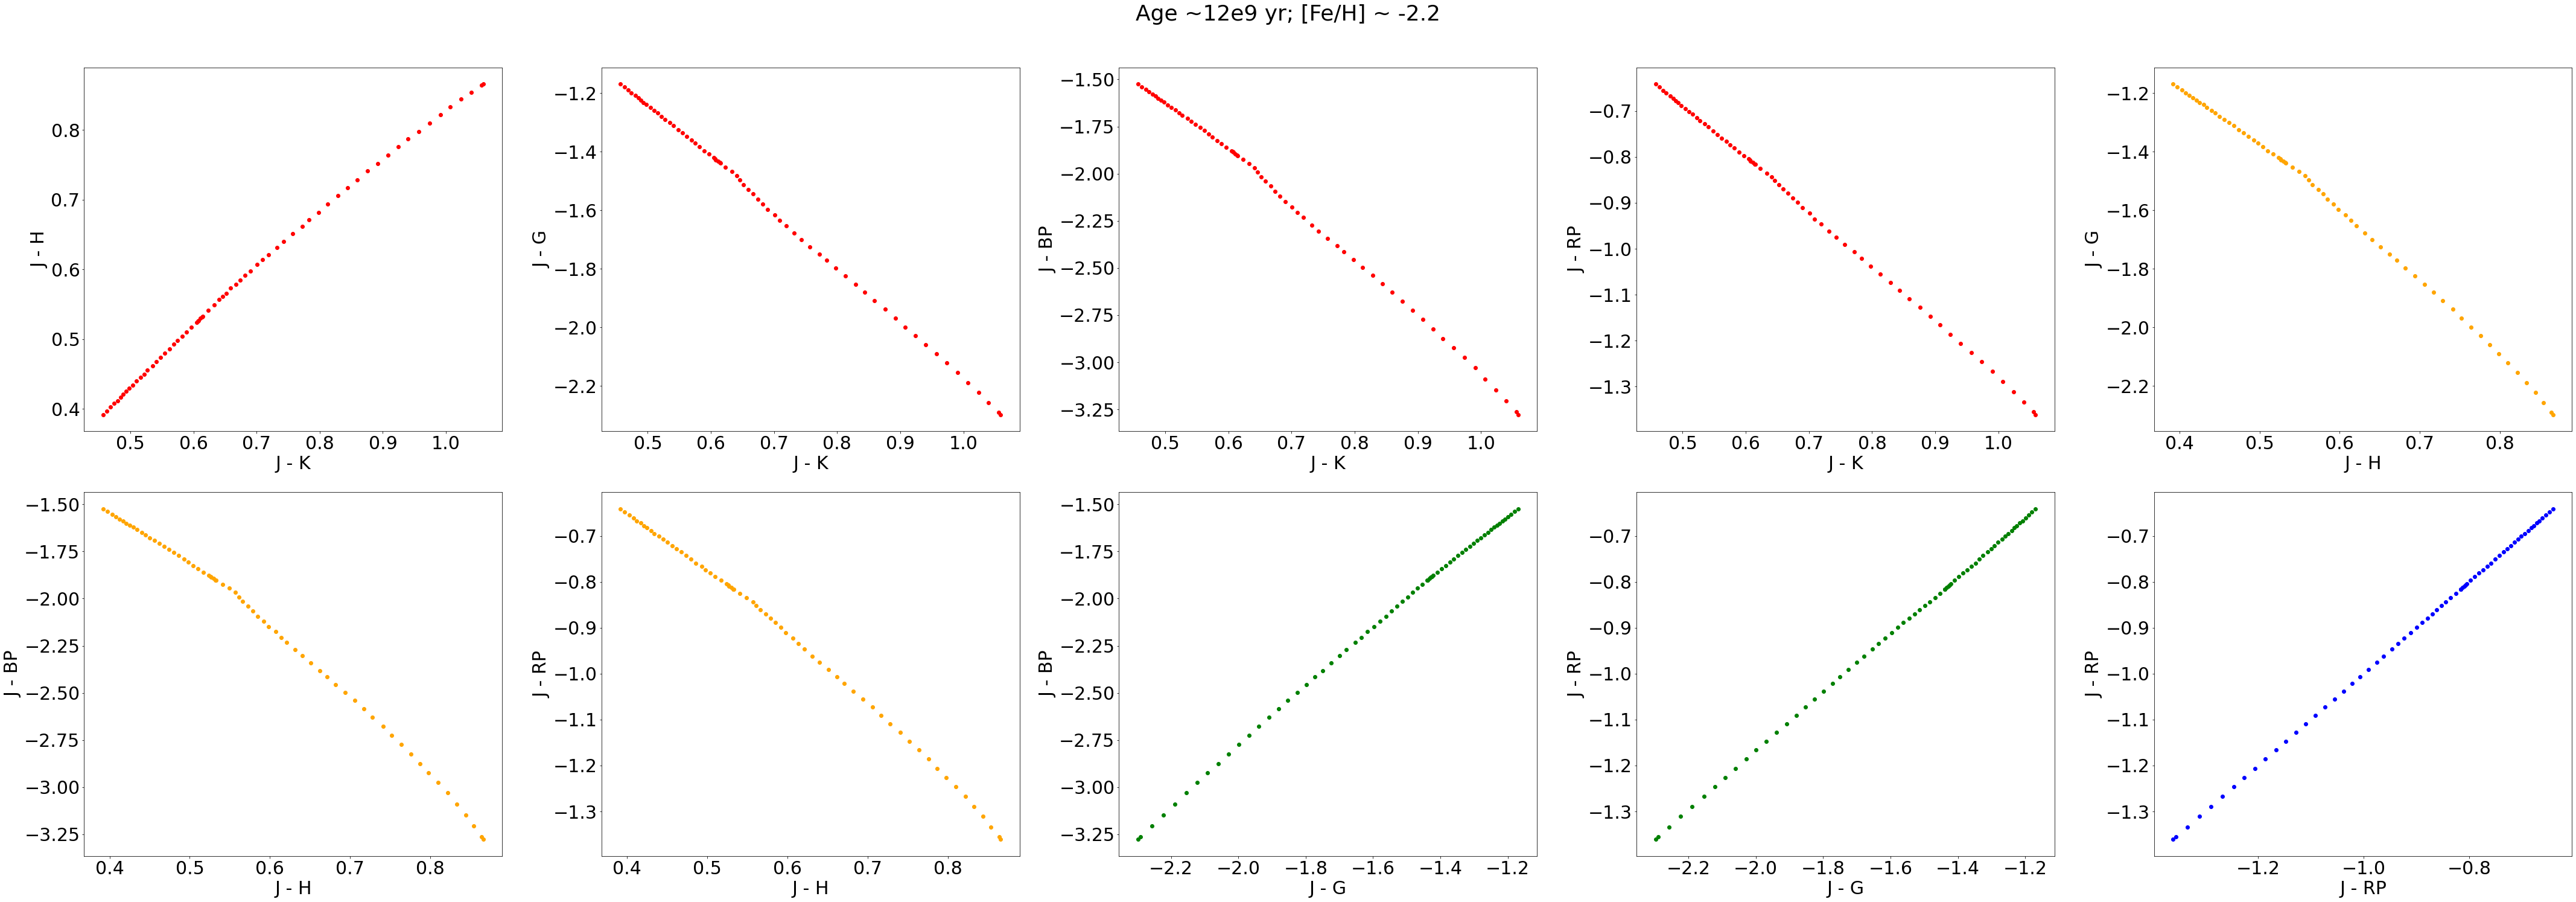

In [9]:
####################################
### Age ~12e9 yr; [Fe/H] ~ -1.0 ###
####################################

xcol10 = [p12e9_1_0['Jmag']-p12e9_1_0['Ksmag'],p12e9_1_0['Jmag']-p12e9_1_0['Ksmag'],
          p12e9_1_0['Jmag']-p12e9_1_0['Ksmag'],p12e9_1_0['Jmag']-p12e9_1_0['Ksmag'],
          p12e9_1_0['Jmag']-p12e9_1_0['Hmag'],p12e9_1_0['Jmag']-p12e9_1_0['Hmag'],
          p12e9_1_0['Jmag']-p12e9_1_0['Hmag'],p12e9_1_0['Jmag']-p12e9_1_0['Gmag'],
          p12e9_1_0['Jmag']-p12e9_1_0['Gmag'],p12e9_1_0['Jmag']-p12e9_1_0['G_RPmag']]

ycol10 = [p12e9_1_0['Jmag']-p12e9_1_0['Hmag'],p12e9_1_0['Jmag']-p12e9_1_0['Gmag'],
          p12e9_1_0['Jmag']-p12e9_1_0['G_BPmag'],p12e9_1_0['Jmag']-p12e9_1_0['G_RPmag'],
          p12e9_1_0['Jmag']-p12e9_1_0['Gmag'],p12e9_1_0['Jmag']-p12e9_1_0['G_BPmag'],
          p12e9_1_0['Jmag']-p12e9_1_0['G_RPmag'],p12e9_1_0['Jmag']-p12e9_1_0['G_BPmag'],
          p12e9_1_0['Jmag']-p12e9_1_0['G_RPmag'],p12e9_1_0['Jmag']-p12e9_1_0['G_RPmag']]

xcol10_lab = ['J - K','J - K','J - K','J - K','J - H','J - H','J - H','J - G','J - G','J - RP']

ycol10_lab = ['J - H','J - G','J - BP','J - RP','J - G','J - BP','J - RP','J - BP','J - RP','J - RP']

colors = ['r','r','r','r','orange','orange','orange','g','g','b']

fig,ax = plt.subplots(2,5,figsize=[60,20])
for i, ax in enumerate(ax.ravel()):
    ax.scatter(xcol10[i],ycol10[i],c=colors[i])
    ax.set_xlabel(xcol10_lab[i])
    ax.set_ylabel(ycol10_lab[i])
plt.tight_layout()
plt.suptitle('Age ~12e9 yr; [Fe/H] ~ -2.2',y=1.05)
plt.show()

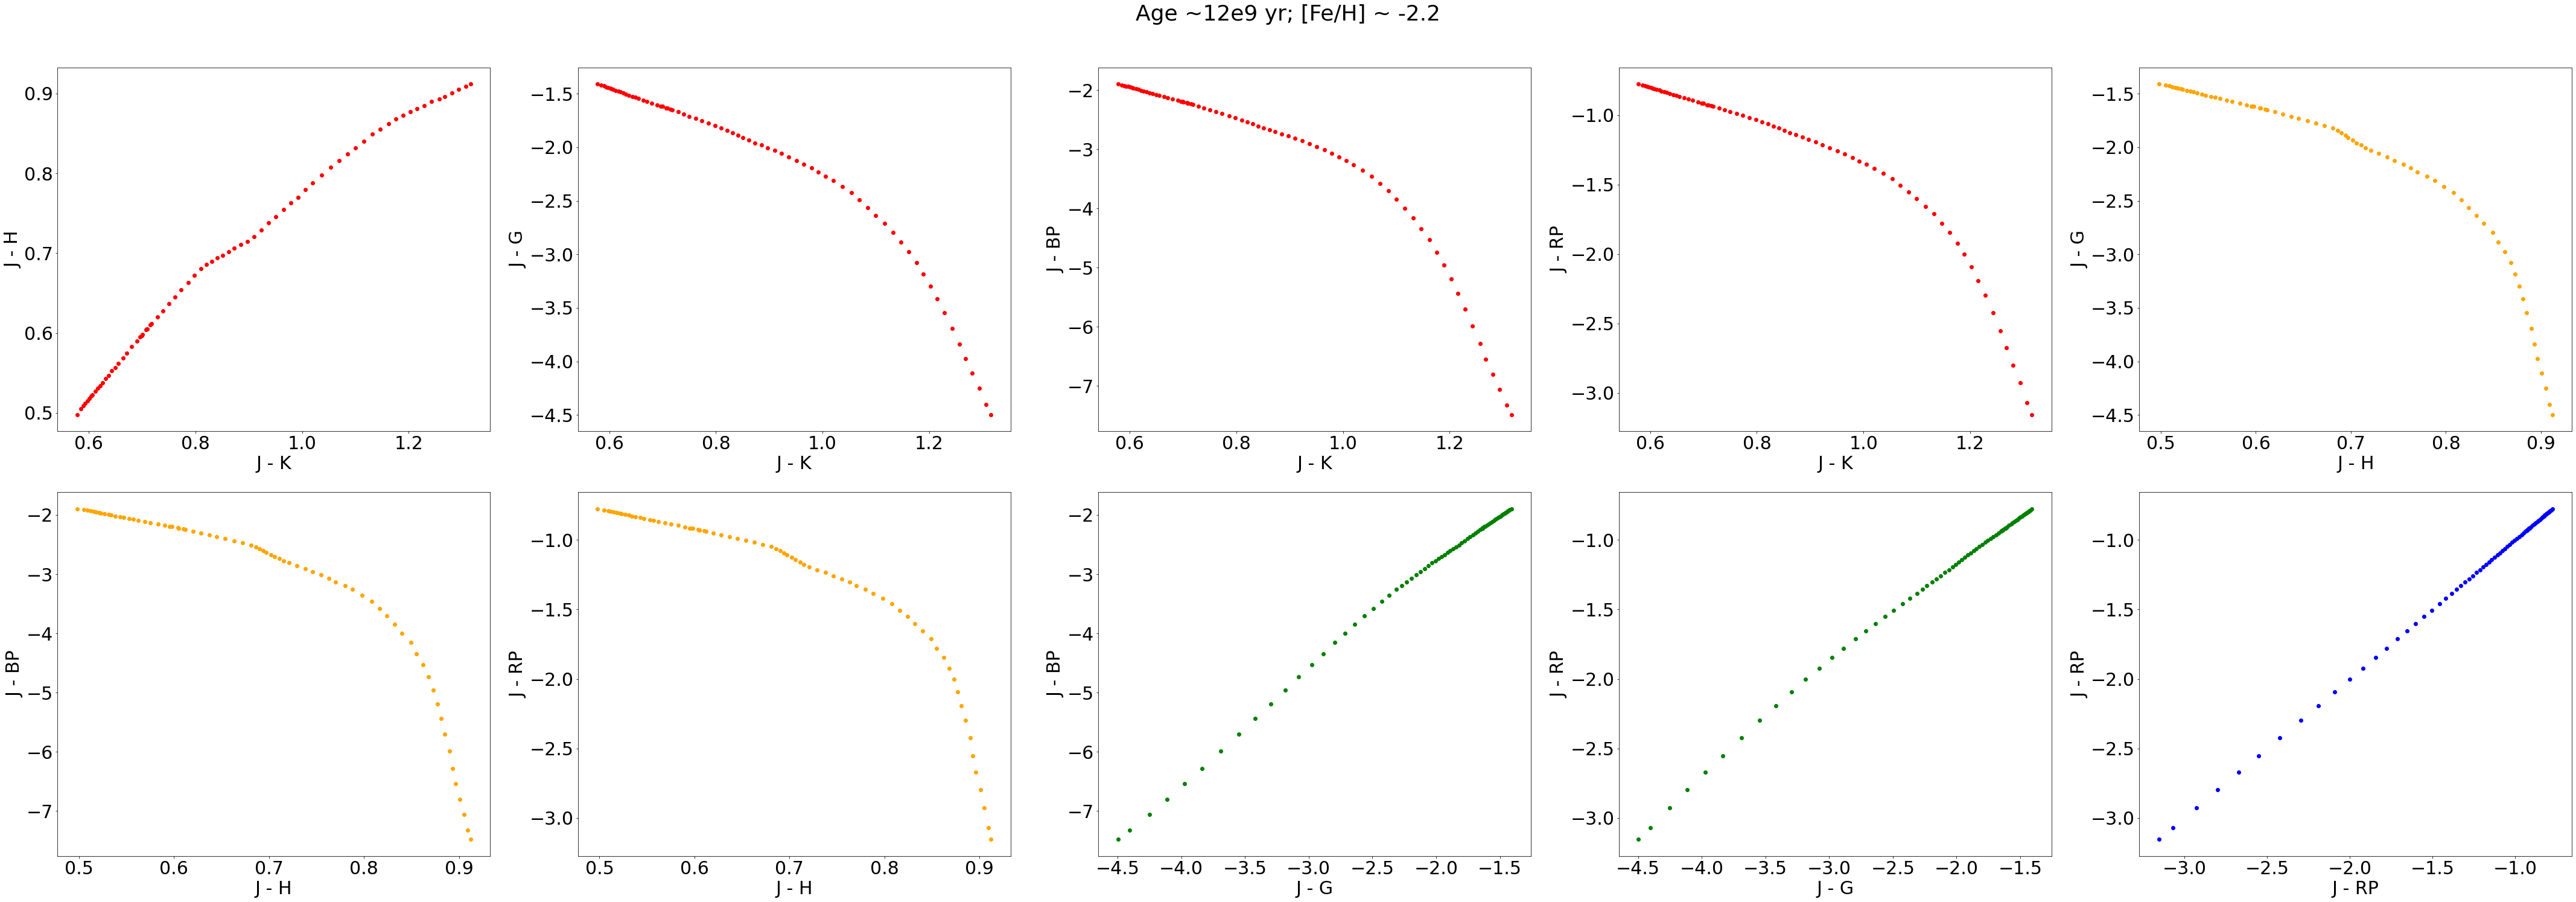

In [10]:
####################################
### Age ~12e9 yr; [Fe/H] ~ -0.0 ###
####################################

xcol00 = [p12e9_0_0['Jmag']-p12e9_0_0['Ksmag'],p12e9_0_0['Jmag']-p12e9_0_0['Ksmag'],
          p12e9_0_0['Jmag']-p12e9_0_0['Ksmag'],p12e9_0_0['Jmag']-p12e9_0_0['Ksmag'],
          p12e9_0_0['Jmag']-p12e9_0_0['Hmag'],p12e9_0_0['Jmag']-p12e9_0_0['Hmag'],
          p12e9_0_0['Jmag']-p12e9_0_0['Hmag'],p12e9_0_0['Jmag']-p12e9_0_0['Gmag'],
          p12e9_0_0['Jmag']-p12e9_0_0['Gmag'],p12e9_0_0['Jmag']-p12e9_0_0['G_RPmag']]

ycol00 = [p12e9_0_0['Jmag']-p12e9_0_0['Hmag'],p12e9_0_0['Jmag']-p12e9_0_0['Gmag'],
          p12e9_0_0['Jmag']-p12e9_0_0['G_BPmag'],p12e9_0_0['Jmag']-p12e9_0_0['G_RPmag'],
          p12e9_0_0['Jmag']-p12e9_0_0['Gmag'],p12e9_0_0['Jmag']-p12e9_0_0['G_BPmag'],
          p12e9_0_0['Jmag']-p12e9_0_0['G_RPmag'],p12e9_0_0['Jmag']-p12e9_0_0['G_BPmag'],
          p12e9_0_0['Jmag']-p12e9_0_0['G_RPmag'],p12e9_0_0['Jmag']-p12e9_0_0['G_RPmag']]

xcol00_lab = ['J - K','J - K','J - K','J - K','J - H','J - H','J - H','J - G','J - G','J - RP']

ycol00_lab = ['J - H','J - G','J - BP','J - RP','J - G','J - BP','J - RP','J - BP','J - RP','J - RP']

colors = ['r','r','r','r','orange','orange','orange','g','g','b']

fig,ax = plt.subplots(2,5,figsize=[60,20])
for i, ax in enumerate(ax.ravel()):
    ax.scatter(xcol00[i],ycol00[i],c=colors[i])
    ax.set_xlabel(xcol00_lab[i])
    ax.set_ylabel(ycol00_lab[i])
plt.tight_layout()
plt.suptitle('Age ~12e9 yr; [Fe/H] ~ -2.2',y=1.05)
plt.show()

In [11]:
p5e9_2_2 = parsec5e9[np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],-2.2)[0])]
p5e9_1_0 = parsec5e9[np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],-1.0)[0])]
p5e9_0_0 = parsec5e9[np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],0.0)[0])]

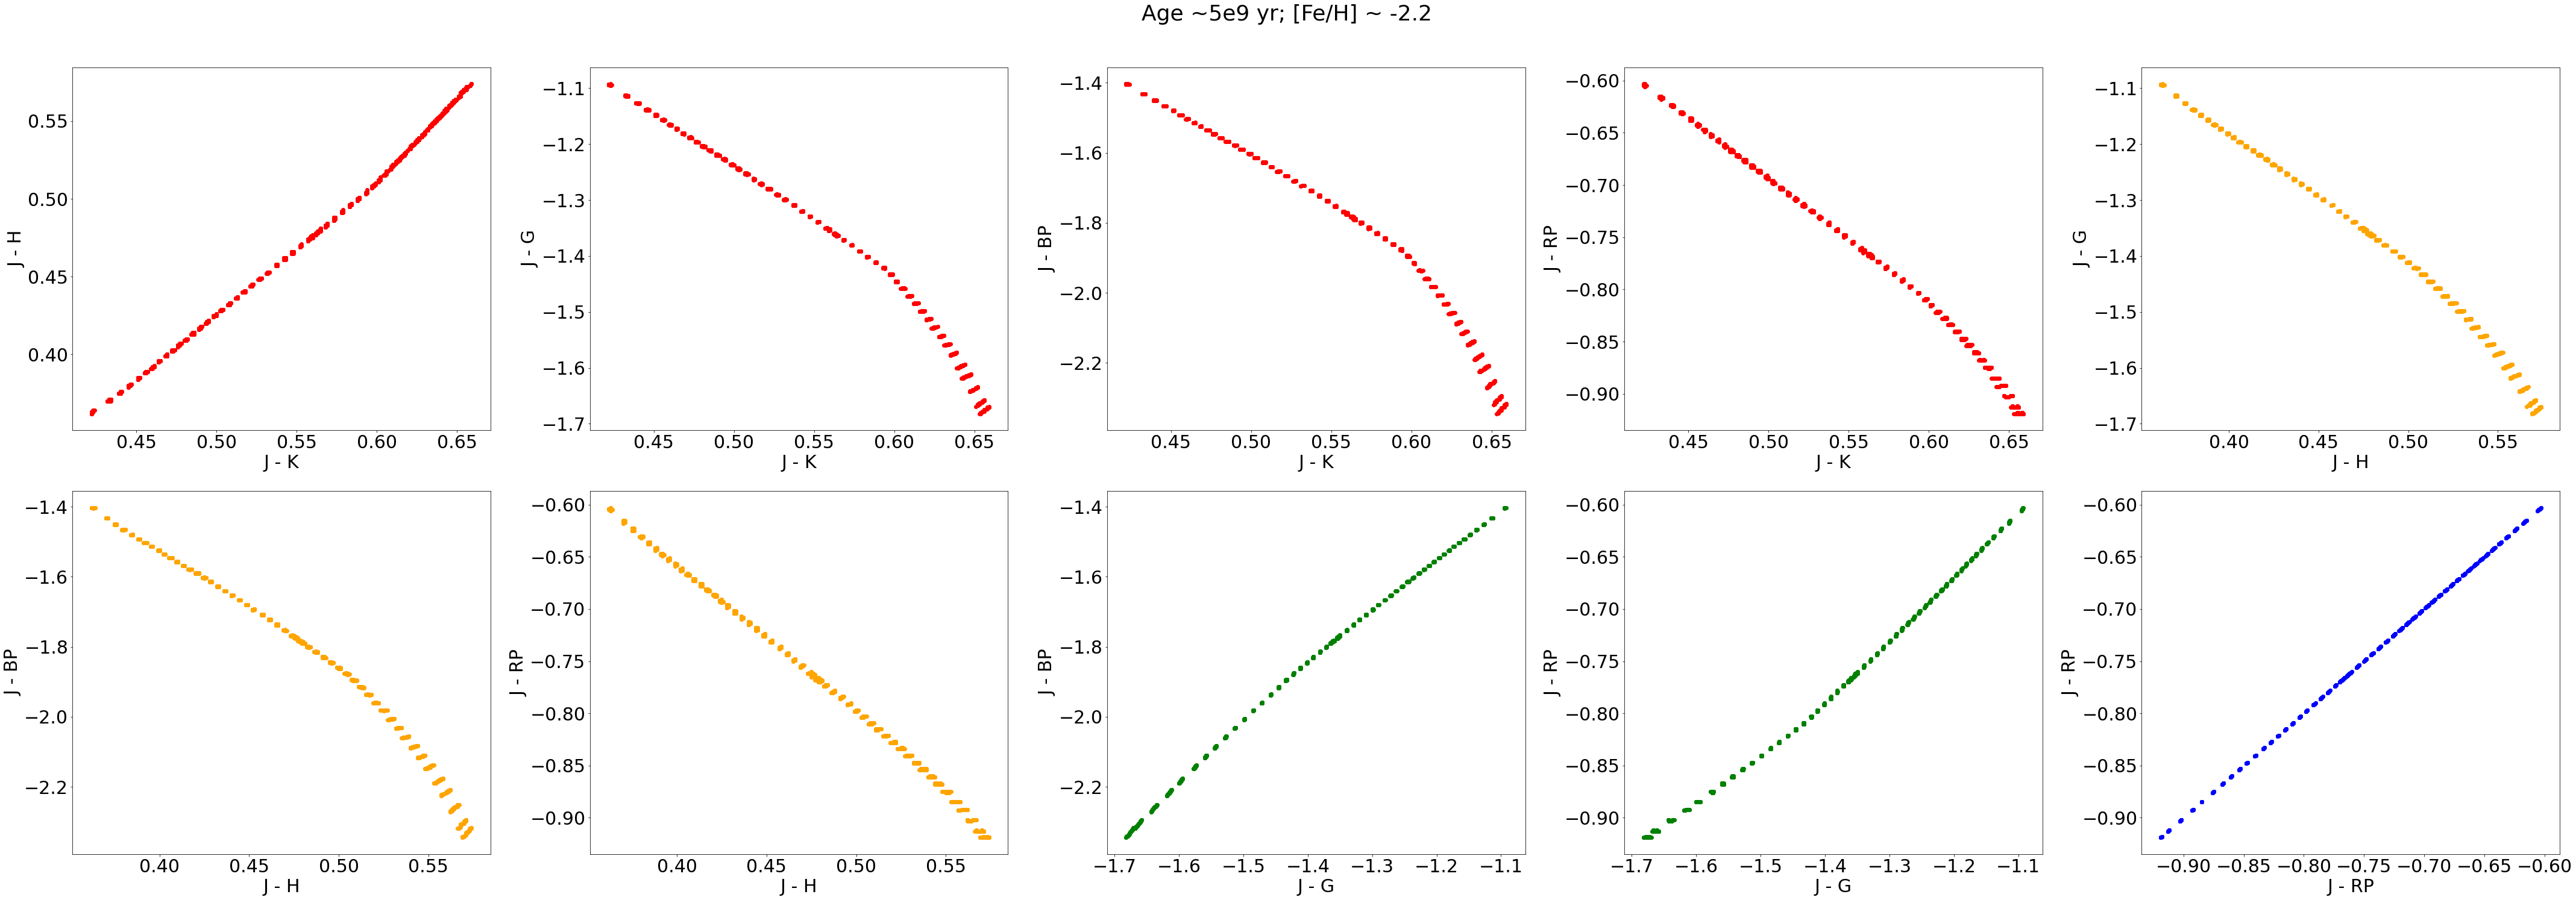

In [12]:
###################################
### Age ~5e9 yr; [Fe/H] ~ -2.2 ###
###################################

xcol22 = [p5e9_2_2['Jmag']-p5e9_2_2['Ksmag'],p5e9_2_2['Jmag']-p5e9_2_2['Ksmag'],
          p5e9_2_2['Jmag']-p5e9_2_2['Ksmag'],p5e9_2_2['Jmag']-p5e9_2_2['Ksmag'],
          p5e9_2_2['Jmag']-p5e9_2_2['Hmag'],p5e9_2_2['Jmag']-p5e9_2_2['Hmag'],
          p5e9_2_2['Jmag']-p5e9_2_2['Hmag'],p5e9_2_2['Jmag']-p5e9_2_2['Gmag'],
          p5e9_2_2['Jmag']-p5e9_2_2['Gmag'],p5e9_2_2['Jmag']-p5e9_2_2['G_RPmag']]

ycol22 = [p5e9_2_2['Jmag']-p5e9_2_2['Hmag'],p5e9_2_2['Jmag']-p5e9_2_2['Gmag'],
          p5e9_2_2['Jmag']-p5e9_2_2['G_BPmag'],p5e9_2_2['Jmag']-p5e9_2_2['G_RPmag'],
          p5e9_2_2['Jmag']-p5e9_2_2['Gmag'],p5e9_2_2['Jmag']-p5e9_2_2['G_BPmag'],
          p5e9_2_2['Jmag']-p5e9_2_2['G_RPmag'],p5e9_2_2['Jmag']-p5e9_2_2['G_BPmag'],
          p5e9_2_2['Jmag']-p5e9_2_2['G_RPmag'],p5e9_2_2['Jmag']-p5e9_2_2['G_RPmag']]

xcol22_lab = ['J - K','J - K','J - K','J - K','J - H','J - H','J - H','J - G','J - G','J - RP']

ycol22_lab = ['J - H','J - G','J - BP','J - RP','J - G','J - BP','J - RP','J - BP','J - RP','J - RP']

colors = ['r','r','r','r','orange','orange','orange','g','g','b']

fig,ax = plt.subplots(2,5,figsize=[60,20])
for i, ax in enumerate(ax.ravel()):
    ax.scatter(xcol22[i],ycol22[i],c=colors[i])
    ax.set_xlabel(xcol22_lab[i])
    ax.set_ylabel(ycol22_lab[i])
plt.tight_layout()
plt.suptitle('Age ~5e9 yr; [Fe/H] ~ -2.2',y=1.05)
plt.show()

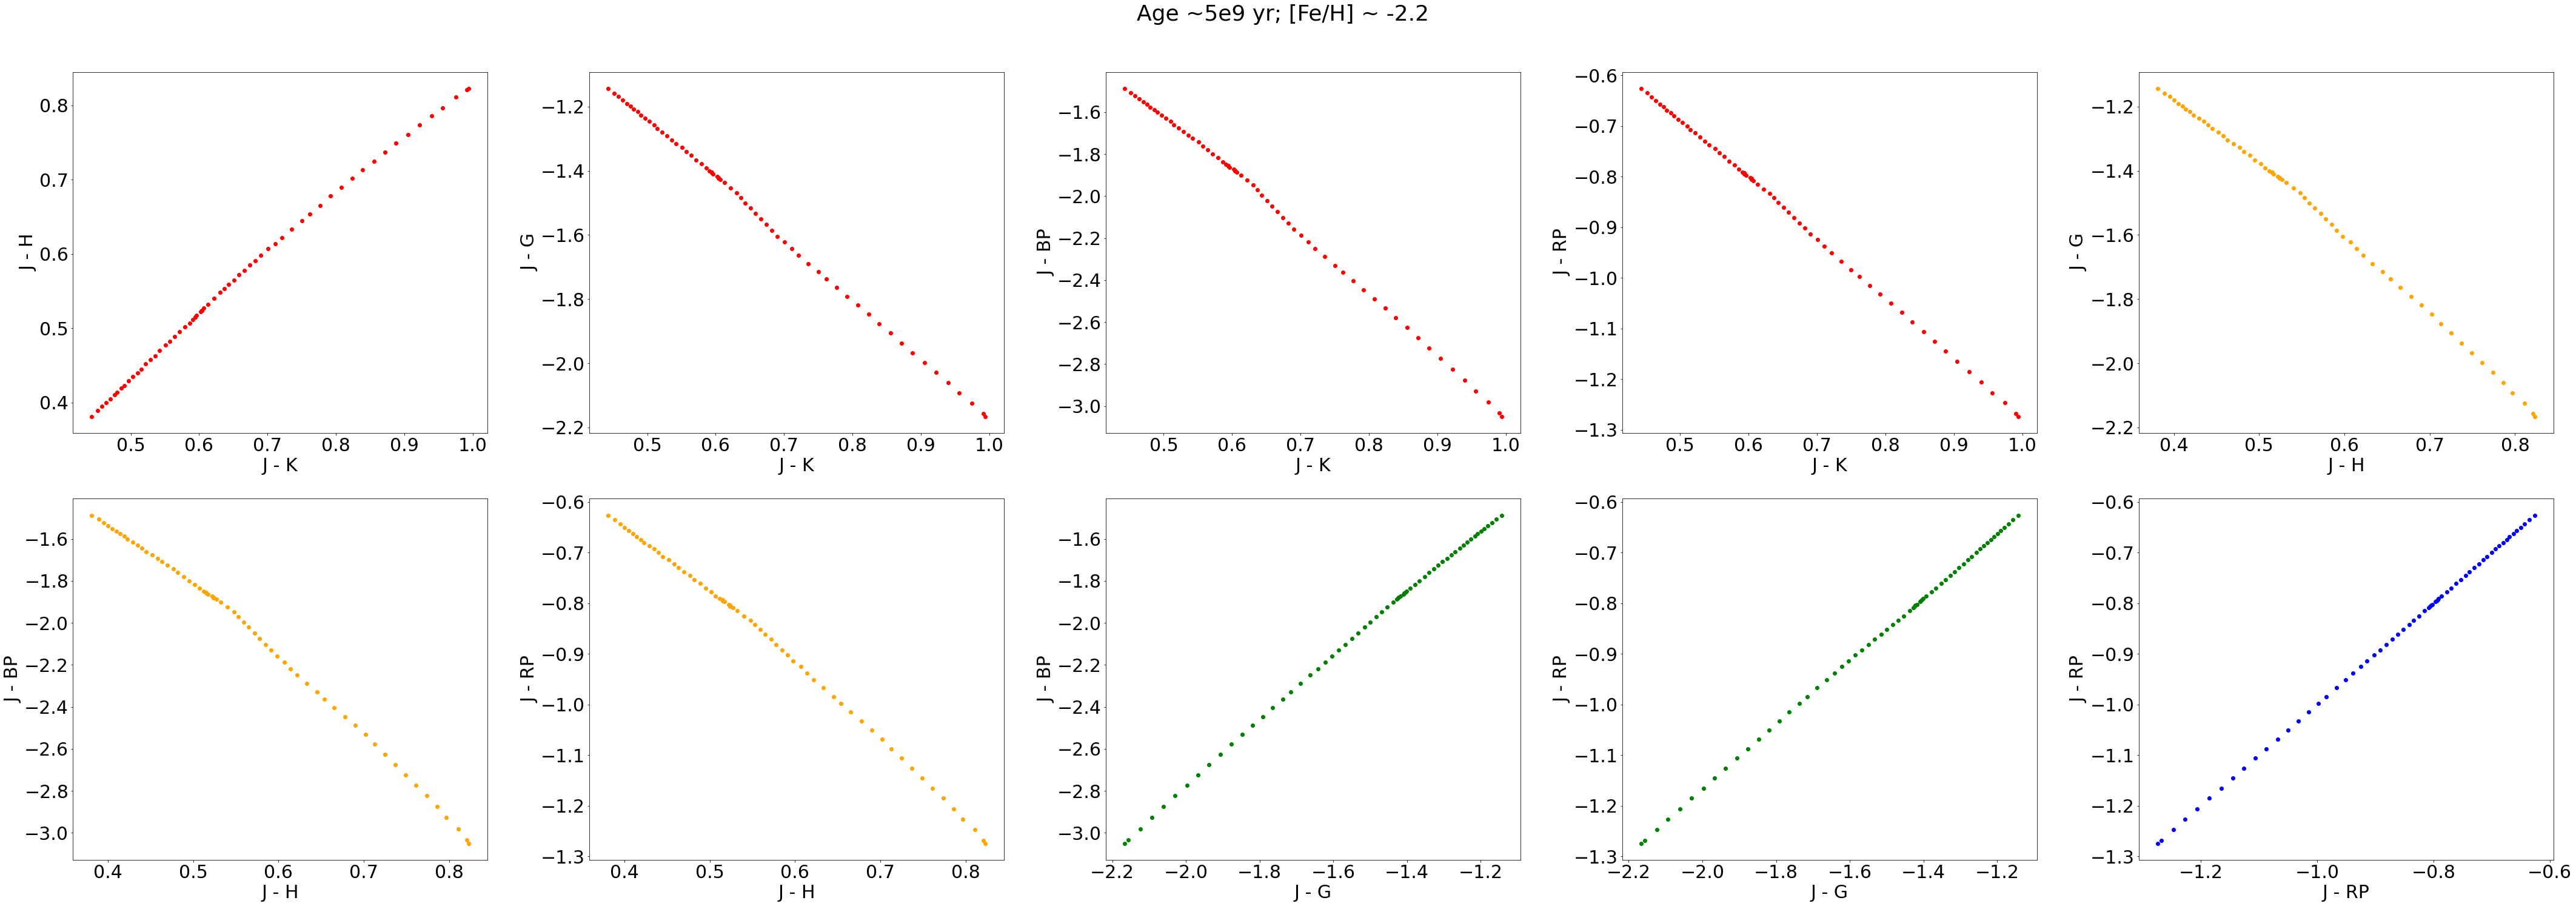

In [13]:
###################################
### Age ~5e9 yr; [Fe/H] ~ -1.0 ###
###################################

xcol10 = [p5e9_1_0['Jmag']-p5e9_1_0['Ksmag'],p5e9_1_0['Jmag']-p5e9_1_0['Ksmag'],
          p5e9_1_0['Jmag']-p5e9_1_0['Ksmag'],p5e9_1_0['Jmag']-p5e9_1_0['Ksmag'],
          p5e9_1_0['Jmag']-p5e9_1_0['Hmag'],p5e9_1_0['Jmag']-p5e9_1_0['Hmag'],
          p5e9_1_0['Jmag']-p5e9_1_0['Hmag'],p5e9_1_0['Jmag']-p5e9_1_0['Gmag'],
          p5e9_1_0['Jmag']-p5e9_1_0['Gmag'],p5e9_1_0['Jmag']-p5e9_1_0['G_RPmag']]

ycol10 = [p5e9_1_0['Jmag']-p5e9_1_0['Hmag'],p5e9_1_0['Jmag']-p5e9_1_0['Gmag'],
          p5e9_1_0['Jmag']-p5e9_1_0['G_BPmag'],p5e9_1_0['Jmag']-p5e9_1_0['G_RPmag'],
          p5e9_1_0['Jmag']-p5e9_1_0['Gmag'],p5e9_1_0['Jmag']-p5e9_1_0['G_BPmag'],
          p5e9_1_0['Jmag']-p5e9_1_0['G_RPmag'],p5e9_1_0['Jmag']-p5e9_1_0['G_BPmag'],
          p5e9_1_0['Jmag']-p5e9_1_0['G_RPmag'],p5e9_1_0['Jmag']-p5e9_1_0['G_RPmag']]

xcol10_lab = ['J - K','J - K','J - K','J - K','J - H','J - H','J - H','J - G','J - G','J - RP']

ycol10_lab = ['J - H','J - G','J - BP','J - RP','J - G','J - BP','J - RP','J - BP','J - RP','J - RP']

colors = ['r','r','r','r','orange','orange','orange','g','g','b']

fig,ax = plt.subplots(2,5,figsize=[60,20])
for i, ax in enumerate(ax.ravel()):
    ax.scatter(xcol10[i],ycol10[i],c=colors[i])
    ax.set_xlabel(xcol10_lab[i])
    ax.set_ylabel(ycol10_lab[i])
plt.tight_layout()
plt.suptitle('Age ~5e9 yr; [Fe/H] ~ -2.2',y=1.05)
plt.show()

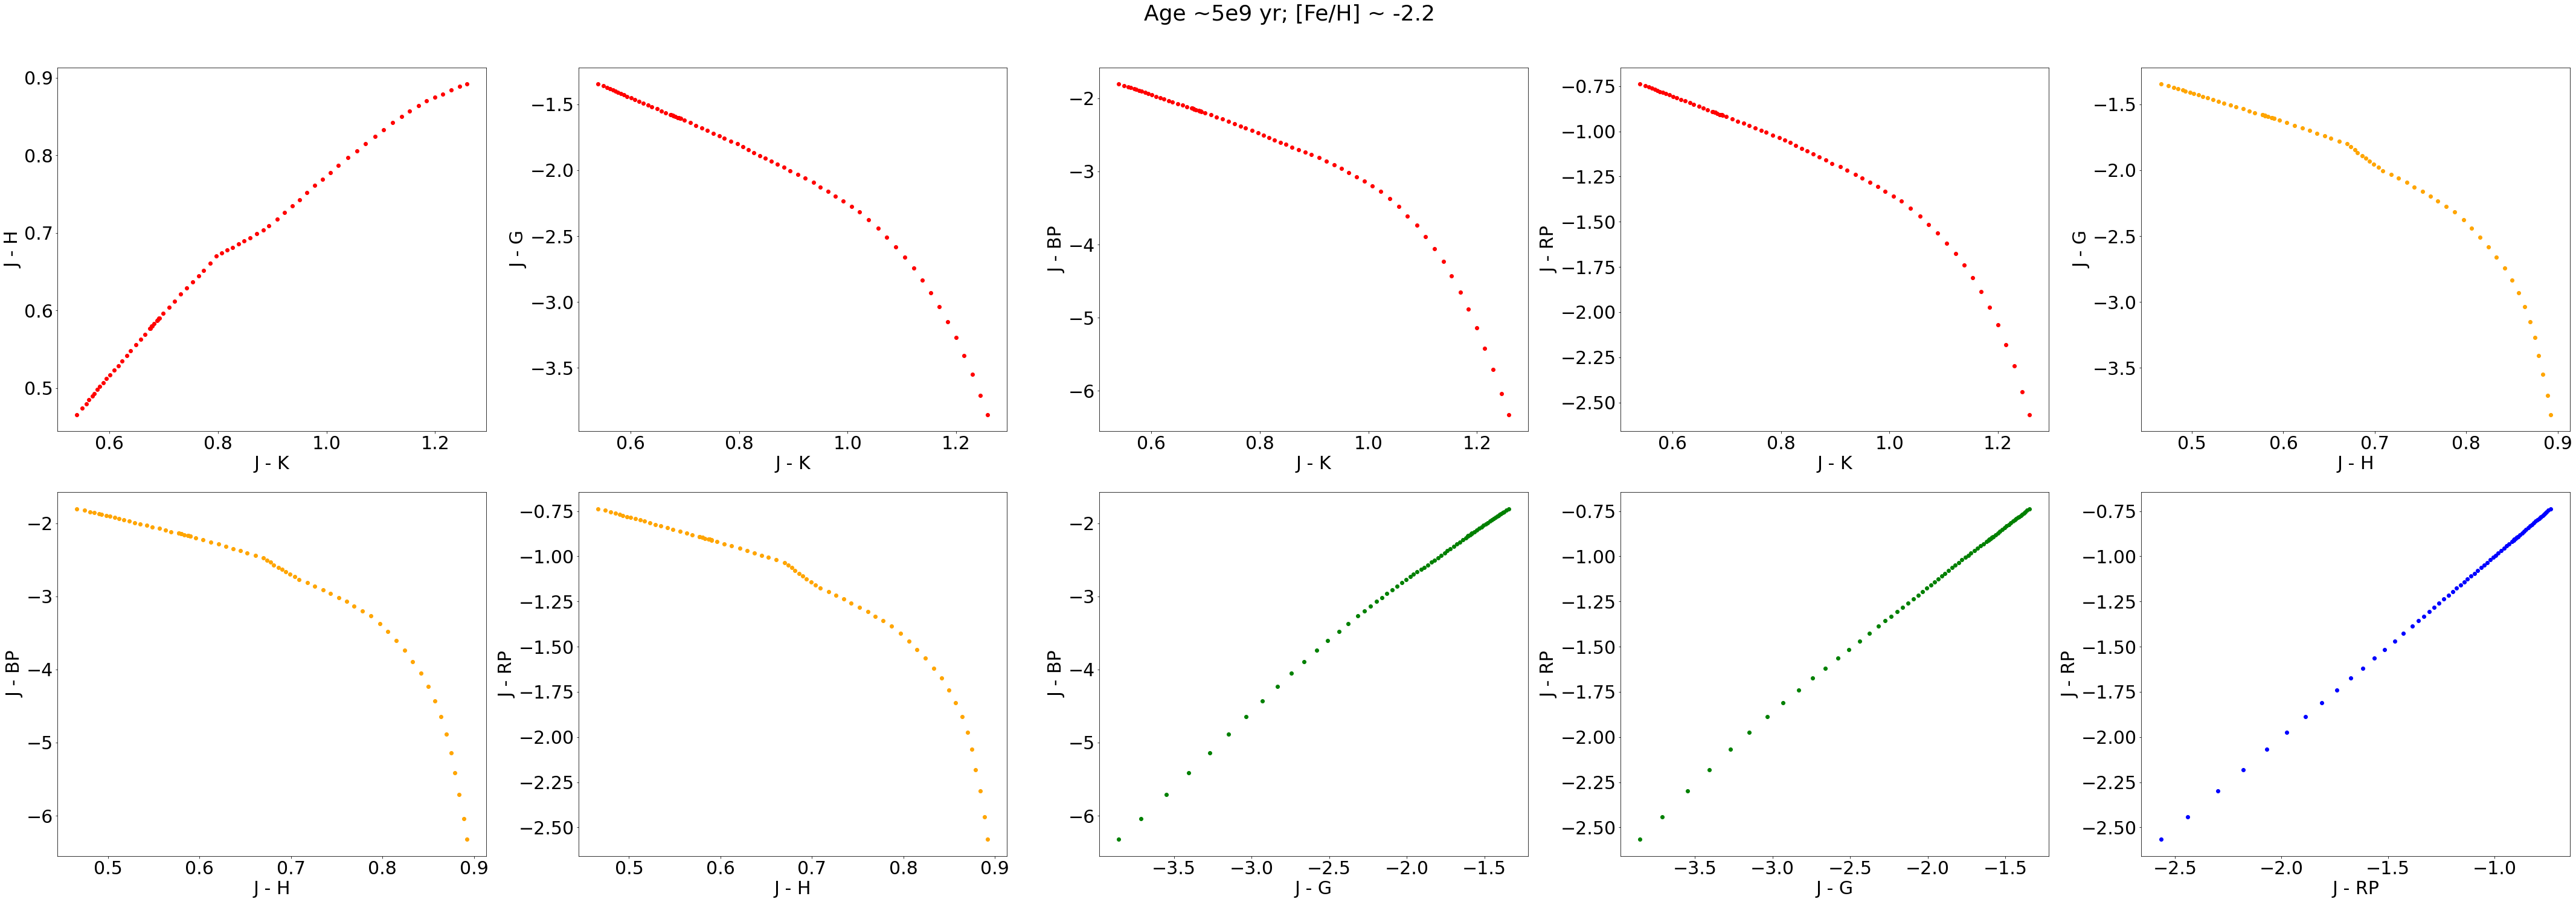

In [14]:
###################################
### Age ~5e9 yr; [Fe/H] ~ -0.0 ###
###################################

xcol00 = [p5e9_0_0['Jmag']-p5e9_0_0['Ksmag'],p5e9_0_0['Jmag']-p5e9_0_0['Ksmag'],
          p5e9_0_0['Jmag']-p5e9_0_0['Ksmag'],p5e9_0_0['Jmag']-p5e9_0_0['Ksmag'],
          p5e9_0_0['Jmag']-p5e9_0_0['Hmag'],p5e9_0_0['Jmag']-p5e9_0_0['Hmag'],
          p5e9_0_0['Jmag']-p5e9_0_0['Hmag'],p5e9_0_0['Jmag']-p5e9_0_0['Gmag'],
          p5e9_0_0['Jmag']-p5e9_0_0['Gmag'],p5e9_0_0['Jmag']-p5e9_0_0['G_RPmag']]

ycol00 = [p5e9_0_0['Jmag']-p5e9_0_0['Hmag'],p5e9_0_0['Jmag']-p5e9_0_0['Gmag'],
          p5e9_0_0['Jmag']-p5e9_0_0['G_BPmag'],p5e9_0_0['Jmag']-p5e9_0_0['G_RPmag'],
          p5e9_0_0['Jmag']-p5e9_0_0['Gmag'],p5e9_0_0['Jmag']-p5e9_0_0['G_BPmag'],
          p5e9_0_0['Jmag']-p5e9_0_0['G_RPmag'],p5e9_0_0['Jmag']-p5e9_0_0['G_BPmag'],
          p5e9_0_0['Jmag']-p5e9_0_0['G_RPmag'],p5e9_0_0['Jmag']-p5e9_0_0['G_RPmag']]

xcol00_lab = ['J - K','J - K','J - K','J - K','J - H','J - H','J - H','J - G','J - G','J - RP']

ycol00_lab = ['J - H','J - G','J - BP','J - RP','J - G','J - BP','J - RP','J - BP','J - RP','J - RP']

colors = ['r','r','r','r','orange','orange','orange','g','g','b']

fig,ax = plt.subplots(2,5,figsize=[60,20])
for i, ax in enumerate(ax.ravel()):
    ax.scatter(xcol00[i],ycol00[i],c=colors[i])
    ax.set_xlabel(xcol00_lab[i])
    ax.set_ylabel(ycol00_lab[i])
plt.tight_layout()
plt.suptitle('Age ~5e9 yr; [Fe/H] ~ -2.2',y=1.05)
plt.show()

<!-- <font size='15'>
    <b>
        Plot Proof of Concept Line
    </b>
</font> -->

In [15]:
def ccline(x,cer,x0,y0):
    ''' 
    Inputs:
    ------
        x: values to plug in [3 - 4]
        cer: color excess ratio [E(1 - 2)/E(3 - 4)]
        x0: color of some point [3 - 4]_0
        y0: color of some point [1 - 2]_0
    '''
#     return np.subtract(np.multiply(x,cer),np.add(x0*cer,y0))
    return np.add(np.multiply(cer,x),np.subtract(y0,np.multiply(cer,x0)))

def ind_alak(wave):
    '''
    Calculate the relative extinction to Ak using Indebetouw et al. 2005.
    This uses GLIMPSE data and has only been verified in IR.
    
    Input:
    -----
        wave: effective wavelength in microns of the passband
        
    Output:
    ------
        alak: A\lambda/Ak
    '''
    alak = 10**(0.61-2.22*np.log10(wave)+1.21*(np.log10(wave)**2))
    return alak

In [16]:
cerjhjk_wang = (0.243-0.131)/(0.243-0.078) #wang et al. 2019
cerjhjk = extinct.cardelli_e12ebv(leff['J'],leff['H'],3.1)/extinct.cardelli_e12ebv(leff['J'],leff['K'],3.1)
cerjhjk_ind = (ind_alak(leff['J'])-ind_alak(leff['H']))/(ind_alak(leff['J'])-ind_alak(leff['K']))

In [17]:
print(cerjhjk_wang)
print(cerjhjk)
print(cerjhjk_ind)

0.6787878787878788
0.6125528264539928
0.6598698921113016


In [18]:
# ####################################
# ### Age ~12e9 yr; [Fe/H] ~ -2.2 ###
# ####################################

# s12_2_2 = np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],-2.2)[0])
# xs = np.linspace(min((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_2_2]),
#                  max((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_2_2]))

# plt.figure(figsize=[12,12])
# plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_2_2],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_2_2])
# plt.scatter(0.65,0.5,s=200,marker='*')
# plt.scatter(0.55,0.44,s=200,marker='*')

# plt.plot(xs,ccline(xs,cerjhjk,0.65,0.5),c='tab:orange',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.65,0.5),c='tab:orange',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.65,0.5),c='tab:orange',ls='--',label='0.660 I05')

# plt.plot(xs,ccline(xs,cerjhjk,0.55,0.44),c='tab:green',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.55,0.44),c='tab:green',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.55,0.44),c='tab:green',ls='--',label='0.660 I05')

# plt.legend()

# plt.grid()

# plt.title(r'Age ~12e9 yr; [Fe/H] ~ -2.2')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

# ####################################
# ### Age ~5e9 yr; [Fe/H] ~ -2.2 ###
# ####################################

# s5_2_2 = np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],-2.2)[0])
# xs = np.linspace(min((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_2_2]),
#                  max((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_2_2]))

# plt.figure(figsize=[12,12])
# plt.scatter((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_2_2],(parsec5e9['Jmag']-parsec5e9['Hmag'])[s5_2_2])
# plt.scatter(0.65,0.5,s=200,marker='*')
# plt.scatter(0.55,0.44,s=200,marker='*')

# plt.plot(xs,ccline(xs,cerjhjk,0.65,0.5),c='tab:orange',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.65,0.5),c='tab:orange',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.65,0.5),c='tab:orange',ls='--',label='0.660 I05')

# plt.plot(xs,ccline(xs,cerjhjk,0.55,0.44),c='tab:green',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.55,0.44),c='tab:green',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.55,0.44),c='tab:green',ls='--',label='0.660 I05')

# plt.legend()

# plt.grid()

# plt.title(r'Age ~5e9 yr; [Fe/H] ~ -2.2')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

In [39]:
# ####################################
# ### Age ~12e9 yr; [Fe/H] ~ -1.0 ###
# ####################################

s12_1_0 = np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],-1.0)[0])
# xs = np.linspace(min((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0]),
#                  max((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0]))

# plt.figure(figsize=[12,12])
# plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_1_0])
# plt.scatter(0.6,0.45,s=200,marker='*')
# plt.scatter(0.55,0.44,s=200,marker='*')

# plt.plot(xs,ccline(xs,cerjhjk,0.6,0.45),c='tab:orange',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.6,0.45),c='tab:orange',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.6,0.45),c='tab:orange',ls='--',label='0.660 I05')

# plt.plot(xs,ccline(xs,cerjhjk,0.55,0.44),c='tab:green',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.55,0.44),c='tab:green',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.55,0.44),c='tab:green',ls='--',label='0.660 I05')

# plt.legend()

# plt.grid()

# plt.title(r'Age ~12e9 yr; [Fe/H] ~ -1.0')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

# ####################################
# ### Age ~5e9 yr; [Fe/H] ~ -1.0 ###
# ####################################

s5_1_0 = np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],-1.0)[0])
# xs = np.linspace(min((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_1_0]),
#                  max((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_1_0]))

# plt.figure(figsize=[12,12])
# plt.scatter((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_1_0],(parsec5e9['Jmag']-parsec5e9['Hmag'])[s5_1_0])
# plt.scatter(0.6,0.45,s=200,marker='*')
# plt.scatter(0.55,0.44,s=200,marker='*')

# plt.plot(xs,ccline(xs,cerjhjk,0.6,0.45),c='tab:orange',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.6,0.45),c='tab:orange',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.6,0.45),c='tab:orange',ls='--',label='0.660 I05')

# plt.plot(xs,ccline(xs,cerjhjk,0.55,0.44),c='tab:green',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.55,0.44),c='tab:green',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.55,0.44),c='tab:green',ls='--',label='0.660 I05')

# plt.legend()

# plt.grid()

# plt.title(r'Age ~5e9 yr; [Fe/H] ~ -1.0')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

In [20]:
# ###################################
# ### Age ~12e9 yr; [Fe/H] ~ 0.0 ###
# ###################################

# s12_0_0 = np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],0.0)[0])
# xs = np.linspace(min((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_0_0]),
#                  max((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_0_0]))

# plt.figure(figsize=[12,12])
# plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_0_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_0_0])
# plt.scatter(0.6,0.45,s=200,marker='*')
# plt.scatter(0.55,0.44,s=200,marker='*')

# plt.plot(xs,ccline(xs,cerjhjk,0.6,0.45),c='tab:orange',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.6,0.45),c='tab:orange',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.6,0.45),c='tab:orange',ls='--',label='0.660 I05')

# plt.plot(xs,ccline(xs,cerjhjk,0.55,0.44),c='tab:green',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.55,0.44),c='tab:green',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.55,0.44),c='tab:green',ls='--',label='0.660 I05')

# plt.legend()

# plt.grid()

# plt.title(r'Age ~12e9 yr; [Fe/H] ~ 0.0')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

# ###################################
# ### Age ~5e9 yr; [Fe/H] ~ 0.0 ###
# ###################################

# s5_0_0 = np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],0.0)[0])
# xs = np.linspace(min((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_0_0]),
#                  max((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_0_0]))

# plt.figure(figsize=[12,12])
# plt.scatter((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_0_0],(parsec5e9['Jmag']-parsec5e9['Hmag'])[s5_0_0])
# plt.scatter(0.6,0.45,s=200,marker='*')
# plt.scatter(0.55,0.44,s=200,marker='*')

# plt.plot(xs,ccline(xs,cerjhjk,0.6,0.45),c='tab:orange',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.6,0.45),c='tab:orange',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.6,0.45),c='tab:orange',ls='--',label='0.660 I05')

# plt.plot(xs,ccline(xs,cerjhjk,0.55,0.44),c='tab:green',ls='-',label='0.458 C89')
# plt.plot(xs,ccline(xs,cerjhjk_wang,0.55,0.44),c='tab:green',ls=':',label='0.679 W19')
# plt.plot(xs,ccline(xs,cerjhjk_ind,0.55,0.44),c='tab:green',ls='--',label='0.660 I05')

# plt.legend()

# plt.grid()

# plt.title(r'Age ~5e9 yr; [Fe/H] ~ 0.0')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

<font size='45'>
    <b>
        Figure Out Where Lines Cross
    </b>
</font>

In [23]:
s12_2_2 = np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],-2.2)[0])
xs = (parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_2_2]
ys = (parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_2_2]

# cross = np.argwhere(np.diff(np.sign(-ys+ccline(xs,cerjhjk,0.65,0.5)))).flatten()

# plt.figure(figsize=[10,10])
# plt.text(0.475,0.575,r'$\frac{E(J - H)}{E(J - K)} = 0.458$ C89')
# plt.scatter(xs,ys)
# plt.scatter(xs[cross],ys[cross],c='tab:red')
# plt.scatter(0.65,0.5,s=300,marker='*')

# plt.plot(xs,ccline(xs,cerjhjk,0.65,0.5),c='tab:orange')

# plt.grid()

# plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -2.2')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

In [24]:
from scipy.stats import binned_statistic

bins = np.arange(np.min(xs),np.max(xs),0.005)
binned_color = binned_statistic(xs, ys, statistic='median', bins=bins)

In [25]:
# cross2 = np.argwhere(np.diff(np.sign(binned_color.statistic-ccline(bins[:-1],cerjhjk,0.65,0.5)))).flatten()

s12_2_2 = np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],-2.2)[0])
# xs = (parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_2_2]
# ys = (parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_2_2]

# plt.figure(figsize=[10,10])
# plt.grid()
# plt.text(0.475,0.575,r'$\frac{E(J - H)}{E(J - K)} = 0.458$ C89')
# plt.scatter(bins[:-1],binned_color.statistic)
# plt.scatter(0.65,0.5,s=300,marker='*')
# plt.scatter(bins[:-1][cross2],binned_color.statistic[cross2],c='tab:red')
# plt.plot(xs,ccline(xs,cerjhjk,0.65,0.5),c='tab:orange')

# plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -2.2')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

In [26]:
# plt.figure(figsize=[10,10])
# plt.grid()
# plt.text(0.475,0.575,r'$\frac{E(J - H)}{E(J - K)} = 0.458$ C89')
# plt.scatter(bins[:-1],binned_color.statistic)
# plt.scatter(0.65,0.5,s=300,marker='*')
# plt.scatter(bins[:-1][cross2],binned_color.statistic[cross2],c='tab:red')

# # plt.scatter(dln.closest((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_2_2],xs[16])[0],ys[dln.closest((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_2_2],xs[16])[1]],c='tab:green')

# plt.axvline(0.504)

# plt.plot(xs,ccline(xs,cerjhjk,0.65,0.5),c='tab:orange')

# plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -2.2')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

In [27]:
from scipy.interpolate import InterpolatedUnivariateSpline

spline = InterpolatedUnivariateSpline(bins[:-1],binned_color.statistic)
y_spl = spline(bins[:-1])
func = y_spl - ccline(bins[:-1],cerjhjk,0.65,0.5)
func_spl = InterpolatedUnivariateSpline(bins[:-1],func)
func_spl.roots()

array([], dtype=float64)

In [28]:
# plt.figure(figsize=[10,10])
# plt.grid()
# plt.text(0.475,0.575,r'$\frac{E(J - H)}{E(J - K)} = 0.458$ C89')
# plt.scatter(bins[:-1],binned_color.statistic)
# plt.scatter(0.65,0.5,s=300,marker='*')
# plt.scatter(bins[:-1][cross2],binned_color.statistic[cross2],c='tab:red')



# plt.axvline(func_spl.roots())

# plt.plot(xs,ccline(xs,cerjhjk,0.65,0.5),c='tab:orange')

# plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -2.2')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

In [29]:
func

array([0.00114907, 0.0020863 , 0.00302354, 0.00396078, 0.00589801,
       0.00583525, 0.00777248, 0.01070972, 0.01164696, 0.01158419,
       0.01252143, 0.01645866, 0.0173959 , 0.01833314, 0.01927037,
       0.01920761, 0.02014484, 0.02108208, 0.02201931, 0.02295655,
       0.02789379, 0.02883102, 0.02976826, 0.03070549, 0.03164273,
       0.03157997, 0.0335172 , 0.03545444, 0.03639167, 0.03732891,
       0.03926615, 0.04020338, 0.04114062, 0.04307785, 0.04401509,
       0.04545232, 0.04888956, 0.0508268 , 0.05376403, 0.05570127,
       0.0586385 , 0.05957574, 0.06351298, 0.06545021, 0.06838745,
       0.07032468, 0.07126192, 0.07219915, 0.07313639, 0.07507363,
       0.07601086])

In [30]:
# from scipy.stats import binned_statistic
# from scipy.interpolate import InterpolatedUnivariateSpline

# def ccline(x,cer,x0,y0):
#     ''' 
#     Inputs:
#     ------
#         x: values to plug in [3 - 4]
#         cer: color excess ratio [E(1 - 2)/E(3 - 4)]
#         x0: color of some point [3 - 4]_0
#         y0: color of some point [1 - 2]_0
#     '''
# #     return np.subtract(np.multiply(x,cer),np.add(x0*cer,y0))
#     return np.add(np.multiply(cer,x),np.subtract(y0,np.multiply(cer,x0)))


def find_cross_jhjk(x0,y0,cer,feh,age,isochrones):
    '''
    Find the intersection point of 
    
    Inputs:
    ------
        x0: J - K color of star
        y0: J - H color of star 
        feh: metallicity of star
        age: age in Gyr
        isochrones: set of parsec isochrones
    
    Outputs:
    -------
        jk_cross: J - K of intersection point
        jh_cross: J - H of intersection point
    '''
    
    single = isochrones[np.where((isochrones['logAge']==dln.closest(isochrones['logAge'],np.log10(age*10**9))[0])&
                                 (isochrones['MH']==dln.closest(isochrones['MH'],feh)[0]))]
    xs = (single['Jmag'] - single['Ksmag'])
    ys = (single['Jmag'] - single['Ksmag'])
    
    bins = np.arange(np.min(xs),np.max(xs),0.005)
    binned_color = binned_statistic(xs, ys, statistic='median', bins=bins).statistic
    
    # Interpolate Isochrone
    spline = InterpolatedUnivariateSpline(bins[:-1],binned_color)
    y_spl = spline(bins[:-1])
    
    # Find roots in difference between the ccline and isochrone
    func = y_spl - ccline(bins[:-1],cerjhjk,x0,y0)
    func_spl = InterpolatedUnivariateSpline(bins[:-1],func)
    jk_cross = func_spl.roots()
    jh_cross = spline(jk_cross)
    
    return list(zip(jk_cross, jh_cross))

In [31]:
single = massive[np.where((massive['logAge']==dln.closest(massive['logAge'],np.log10(12*10**9))[0])&
                                (massive['MH']==dln.closest(massive['MH'],-0.5)[0]))]

In [32]:
# xs = (single['Jmag']-single['Ksmag'])
# ys = (single['Jmag']-single['Hmag'])

# bins = np.arange(np.min(xs),np.max(xs),0.001)
# binned_color = binned_statistic(xs, ys, statistic='median', bins=bins)
# # print(bins)
# # print(binned_color.statistic)

# fin = np.where((np.isfinite(bins[:-1])==True)&(np.isfinite(binned_color.statistic)==True))
    
# bins = bins[:-1][fin]
# binned_color = binned_color.statistic[fin]

# print(bins)
# print(binned_color)

# spline = InterpolatedUnivariateSpline(bins,binned_color)
# y_spl = spline(bins)
# func = y_spl - ccline(bins,cerjhjk,0.95,0.8)
# func_spl = InterpolatedUnivariateSpline(bins,func)
# print(func_spl.roots())


# plt.figure(figsize=[10,10])
# plt.grid()
# # plt.text(0.475,0.575,r'$\frac{E(J - H)}{E(J - K)} = 0.458$ C89')
# plt.scatter(bins,binned_color)
# # plt.scatter(single['Jmag']-single['Ksmag'],single['Jmag']-single['Hmag'])
# # plt.scatter(0.65,0.5,s=300,marker='*')
# # plt.scatter(bins[:-1][cross2],binned_color.statistic[cross2],c='tab:red')

# # plt.axvline(func_spl.roots())

# plt.plot(xs,ccline(xs,cerjhjk,0.95,0.8),c='tab:orange')

# # plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -2.2')
# plt.xlabel(r'J - K')
# plt.ylabel(r'J - H')
# plt.show()

In [33]:
# # Find the crossing point
# x0 = 0.95
# y0 = 0.8
# if y0 - spline(x0)>0:
#     # what to do if star is above isochrone in color-color space
#     print(-9999.0)

# else:
#     # Find roots in difference between the ccline and isochrone
#     func = y_spl - ccline(bins,cerjhjk,x0,y0)
#     func_spl = InterpolatedUnivariateSpline(bins,func,ext=0)
#     jk_cross = func_spl.roots()
#     jh_cross = spline(jk_cross)
        
#     if len(jk_cross)==0:
#         # If jk_cross is empty 
#         print(-9999.0)
        
#     else:
#         # Return Cartesian coordinates of crossing point in color-color space
#         print(list(zip(jk_cross, jh_cross)))

In [34]:
# plt.scatter(gcs['J']-gcs['K'],gcs['J']-gcs['H'])

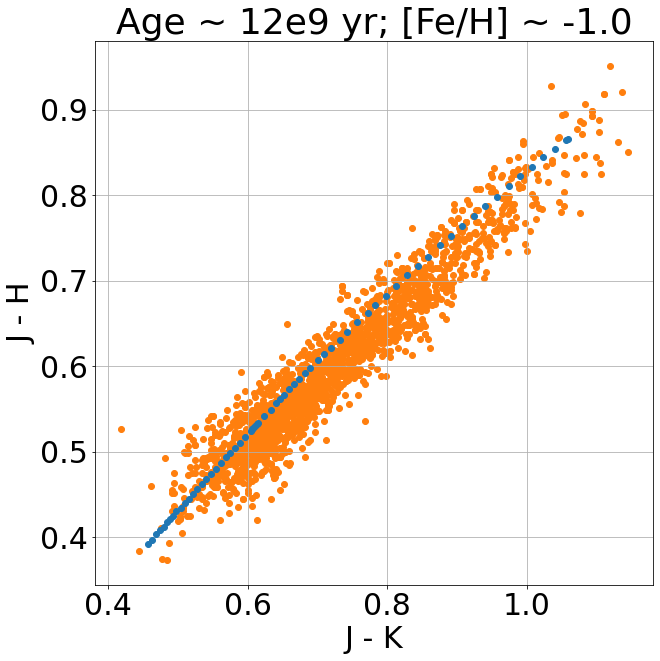

In [37]:
### Plot of GCs stars and a single isochrone

plt.figure(figsize=[10,10])
plt.grid()
plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_1_0],
            zorder=2)
plt.scatter(gcs['J']-gcs['K'],gcs['J']-gcs['H'],zorder=1)
plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -1.0')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.show()

Text(0, 0.5, 'J - H')

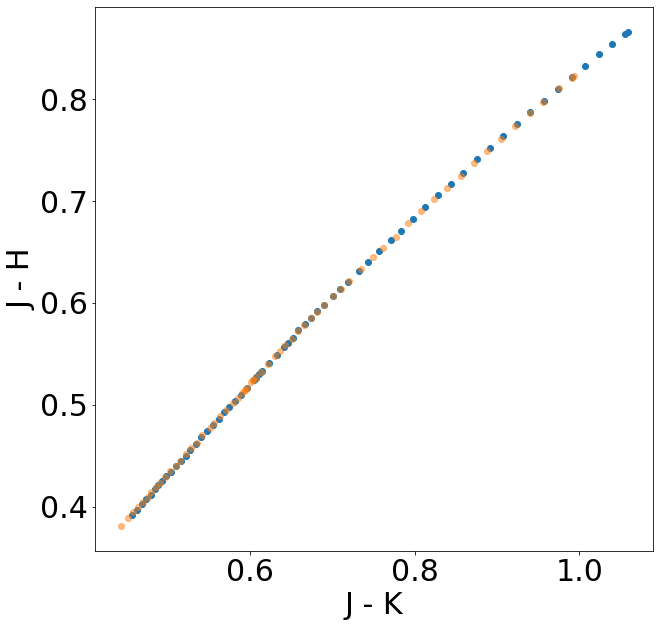

In [40]:
### Compare 12 Gyr and 5 Gyr isochrones with [Fe/H] 

plt.figure(figsize=[10,10])
plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_1_0])
plt.scatter((parsec5e9['Jmag']-parsec5e9['Ksmag'])[s5_1_0],(parsec5e9['Jmag']-parsec5e9['Hmag'])[s5_1_0],alpha=0.5)

# plt.plot(xs,ccline(xs,cerjhjk,xs[0],ys[0]),c='k')

plt.xlabel(r'J - K')
plt.ylabel(r'J - H')

In [41]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    
    Output:
    ------
        value in dat closest to val
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

def parsec_locus_jhjk(x0,y0,cer,feh,age,isochrones):
    '''
    Find the where a star would be located on the stellar locus in (J - K)-(J - H) color space.
    (J - K) is the abscissa and (J - H) is the ordinate.
    
    Inputs:
    ------
        x0: J - K color of star
        y0: J - H color of star
        cer: color excess ratio [E(J - H)/E(J - K)]
        feh: metallicity of star
        age: age in Gyr
        isochrones: set of parsec isochrones
    
    Outputs:
    -------
        jk_cross: J - K of intersection point
        jh_cross: J - H of intersection point
    '''
    single = isochrones[np.where((isochrones['logAge']==closest(np.log10(age*10**9),isochrones['logAge']))&
                             (isochrones['MH']==closest(feh,isochrones['MH'])))]
    xs = (single['Jmag'] - single['Ksmag'])
    ys = (single['Jmag'] - single['Hmag'])
    
    bins = np.arange(np.min(xs),np.max(xs),0.005)
    binned_color = binned_statistic(xs, ys, statistic='median', bins=bins).statistic
    
    fin = np.where((np.isfinite(bins[:-1])==True)&(np.isfinite(binned_color)==True))
    
    bins = bins[:-1][fin]
    binned_color = binned_color[fin]
    
    # Interpolate Isochrone
    spline = InterpolatedUnivariateSpline(bins,binned_color,ext=0)
    y_spl = spline(bins)
    
    # Find the crossing point
    if y0 - spline(x0)>0:
        # what to do if star is above isochrone in color-color space
        return np.squeeze([-9999.0,-9999.0])

    else:
        # Find roots in difference between the ccline and isochrone
        func = y_spl - ccline(bins,cer,x0,y0)
        func_spl = InterpolatedUnivariateSpline(bins,func,ext=0)
        jk_cross = func_spl.roots()
        jh_cross = spline(jk_cross)
        
        if len(jk_cross)==0:
            # If cross12 is empty 
            return np.squeeze([-9999.0,-9999.0])
        
        else:
            # Return Cartesian coordinates of crossing point in color-color space
            return np.squeeze(list(zip(jk_cross, jh_cross)))


Number of Good Stars:  1328
Bad Star Fraction:  0.35345666991236613


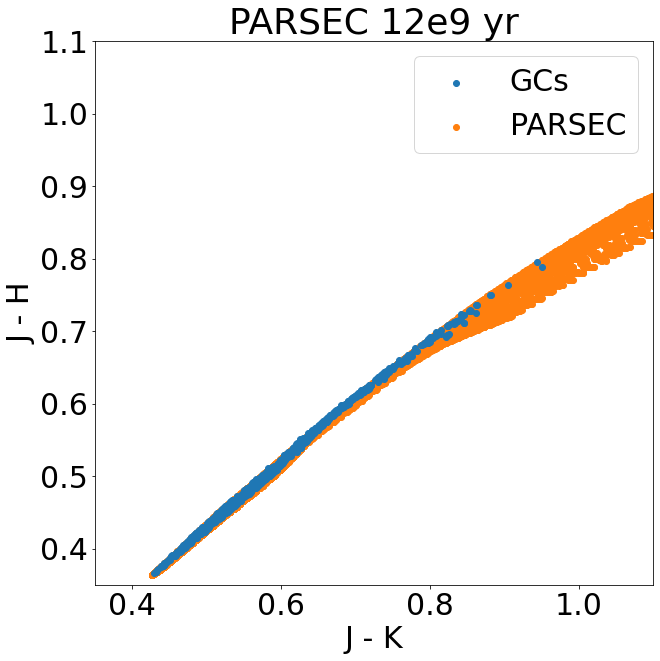

In [42]:
#################################
### Calculate Crossing Points ###
#################################

cross = []
for i in tqdm_notebook(range(len(gcs))):
    cross.append(extinct.parsec_locus_jhjk(gcs['J'][i]-gcs['K'][i],gcs['J'][i]-gcs['H'][i],cerjhjk,gcs['FE_H'][i],
                                         12,parsec12e9))
    
for i in range(len(cross)):
    if np.shape(cross[i])!=(2,):
        cross[i] = np.array([-9999.0,-9999.0])
        
jk_int = []
jh_int = []
for i in range(len(cross)):
    jk_int.append(cross[i][0])
    jh_int.append(cross[i][1])
    
jk_int = np.asarray(jk_int)
jh_int = np.asarray(jh_int)

print('Number of Good Stars: ',len(np.squeeze(np.where(jk_int!=-9999.0))))
print('Bad Star Fraction: ', len(np.squeeze(np.where(jk_int==-9999.0)))/len(jk_int))

plt.figure(figsize=[10,10])
plt.scatter(jk_int,jh_int,zorder=2,label='GCs')
plt.scatter(parsec12e9['Jmag']-parsec12e9['Ksmag'],parsec12e9['Jmag']-parsec12e9['Hmag'],zorder=1,label='PARSEC')
plt.legend()
plt.xlim(0.35,1.1)
plt.ylim(0.35,1.1)

plt.title(r'PARSEC 12e9 yr')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.show()

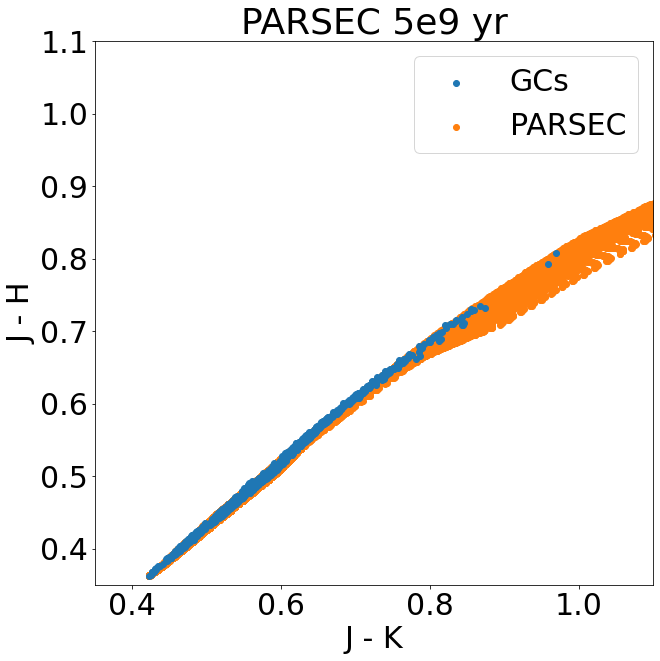

In [43]:
cross5 = []
for i in tqdm_notebook(range(len(gcs))):
    cross5.append(extinct.parsec_locus_jhjk(gcs['J'][i]-gcs['K'][i],gcs['J'][i]-gcs['H'][i],cerjhjk,
                                            gcs['FE_H'][i],5,parsec5e9))
    
for i in range(len(cross5)):
    if cross5[i].size>2:
        cross5[i] = np.array([-9999.0,-9999.0])
        
jk_int5 = []
jh_int5 = []
for i in range(len(cross5)):
    jk_int5.append(cross5[i][0])
    jh_int5.append(cross5[i][1])
    
jk_int5 = np.asarray(jk_int5)
jh_int5 = np.asarray(jh_int5)

# print('Number of Good Stars: ',len(np.squeeze(np.where(jk_int5!=-9999.0))))
# print('Bad Star Fraction: ', len(np.squeeze(np.where(jk_int5==-9999.0)))/len(jk_int5))

plt.figure(figsize=[10,10])
plt.scatter(jk_int5,jh_int5,zorder=2,label='GCs')
plt.scatter(parsec5e9['Jmag']-parsec5e9['Ksmag'],parsec5e9['Jmag']-parsec5e9['Hmag'],zorder=1,label='PARSEC')
plt.legend()
plt.xlim(0.35,1.1)
plt.ylim(0.35,1.1)

plt.title(r'PARSEC 5e9 yr')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.show()


Number of Good Stars:  1410
Bad Star Fraction:  0.31353456669912366


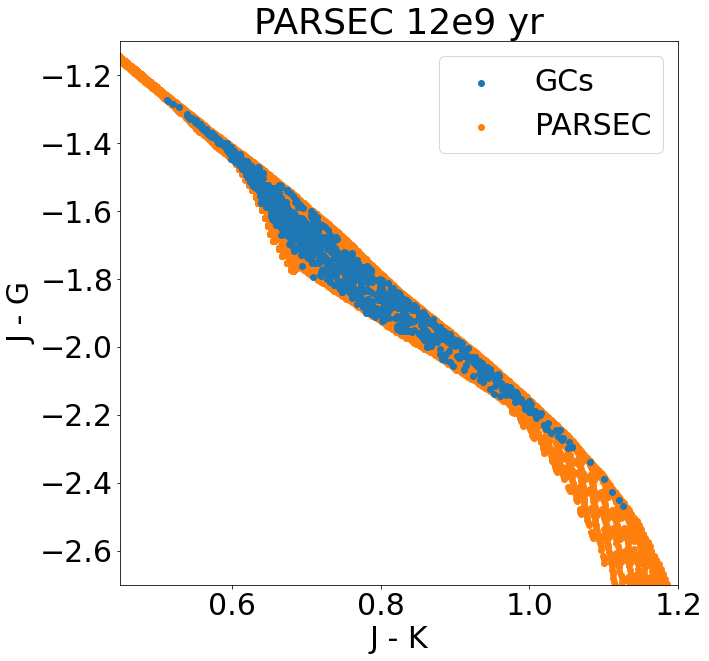

In [44]:
cross_jkjg = []
for i in tqdm_notebook(range(len(gcs))):
    cross_jkjg.append(extinct.parsec_locus(gcs['J'][i]-gcs['K'][i],gcs['J'][i]-gcs['GAIA_PHOT_G_MEAN_MAG'][i],
                                           'Jmag','Ksmag','Jmag','Gmag',cerjhjk,gcs['FE_H'][i],12,parsec12e9))
    
for i in range(len(cross_jkjg)):
    if np.shape(cross_jkjg[i])!=(2,) or cross_jkjg[i].size>2:
        cross_jkjg[i] = np.array([-9999.0,-9999.0])
        
jk_int_jkjg = []
jg_int_jkjg = []
for i in range(len(cross_jkjg)):
    jk_int_jkjg.append(cross_jkjg[i][0])
    jg_int_jkjg.append(cross_jkjg[i][1])
    
jk_int_jkjg = np.asarray(jk_int_jkjg)
jg_int_jkjg = np.asarray(jg_int_jkjg)

print('Number of Good Stars: ',len(np.squeeze(np.where(jk_int_jkjg!=-9999.0))))
print('Bad Star Fraction: ', len(np.squeeze(np.where(jk_int_jkjg==-9999.0)))/len(jk_int_jkjg))

plt.figure(figsize=[10,10])
plt.scatter(jk_int_jkjg,jg_int_jkjg,zorder=2,label='GCs')
plt.scatter(parsec12e9['Jmag']-parsec12e9['Ksmag'],parsec12e9['Jmag']-parsec12e9['Gmag'],zorder=1,label='PARSEC')
plt.legend()
plt.xlim(0.45,1.2)
plt.ylim(-2.7,-1.1)

plt.title(r'PARSEC 12e9 yr')
plt.xlabel(r'J - K')
plt.ylabel(r'J - G')
plt.show()


Number of Good Stars:  1366
Bad Star Fraction:  0.3349561830574489


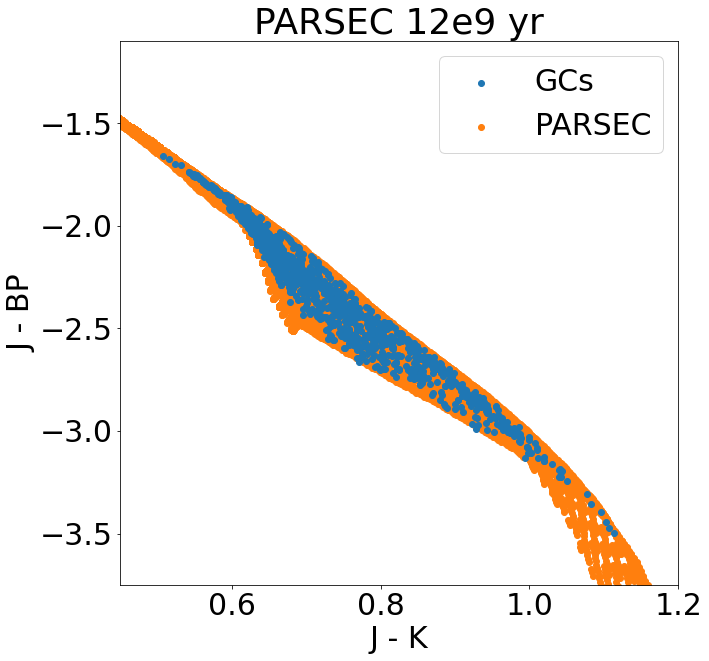

In [45]:
cross_jkjbp = []
for i in tqdm_notebook(range(len(gcs))):
    cross_jkjbp.append(extinct.parsec_locus(gcs['J'][i]-gcs['K'][i],gcs['J'][i]-gcs['GAIA_PHOT_BP_MEAN_MAG'][i],
                                           'Jmag','Ksmag','Jmag','G_BPmag',cerjhjk,gcs['FE_H'][i],12,parsec12e9))
    
for i in range(len(cross_jkjbp)):
    if np.shape(cross_jkjbp[i])!=(2,):
        cross_jkjbp[i] = np.array([-9999.0,-9999.0])
        
jk_int_jkjbp = []
jbp_int_jkjbp = []
for i in range(len(cross_jkjbp)):
    jk_int_jkjbp.append(cross_jkjbp[i][0])
    jbp_int_jkjbp.append(cross_jkjbp[i][1])
    
jk_int_jkjbp = np.asarray(jk_int_jkjbp)
jbp_int_jkjbp = np.asarray(jbp_int_jkjbp)

print('Number of Good Stars: ',len(np.squeeze(np.where(jk_int_jkjbp!=-9999.0))))
print('Bad Star Fraction: ', len(np.squeeze(np.where(jk_int_jkjbp==-9999.0)))/len(jk_int_jkjbp))

plt.figure(figsize=[10,10])
plt.scatter(jk_int_jkjbp,jbp_int_jkjbp,zorder=2,label='GCs')
plt.scatter(parsec12e9['Jmag']-parsec12e9['Ksmag'],parsec12e9['Jmag']-parsec12e9['G_BPmag'],zorder=1,
            label='PARSEC')
plt.legend()
plt.xlim(0.45,1.2)
plt.ylim(-3.75,-1.1)

plt.title(r'PARSEC 12e9 yr')
plt.xlabel(r'J - K')
plt.ylabel(r'J - BP')
plt.show()


Number of Good Stars:  1345
Bad Star Fraction:  0.34518013631937683


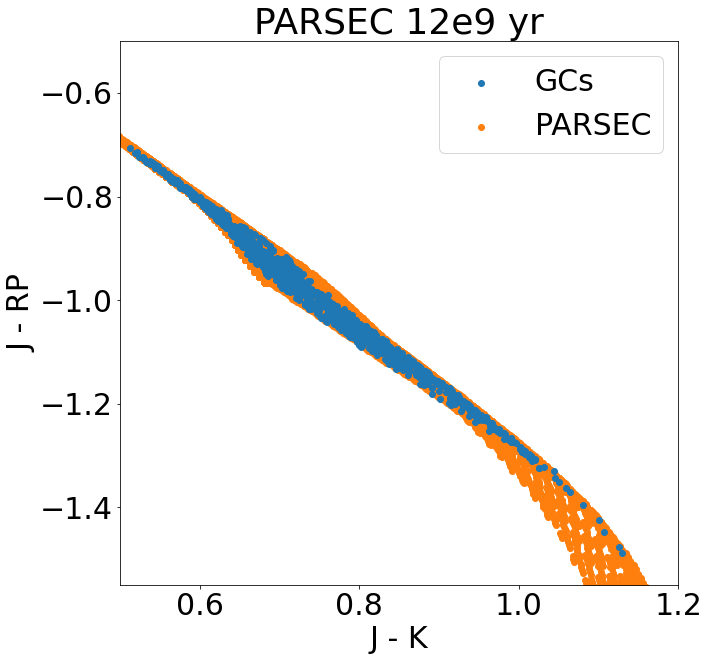

In [46]:
cross_jkjrp = []
for i in tqdm_notebook(range(len(gcs))):
    cross_jkjrp.append(extinct.parsec_locus(gcs['J'][i]-gcs['K'][i],gcs['J'][i]-gcs['GAIA_PHOT_RP_MEAN_MAG'][i],
                                           'Jmag','Ksmag','Jmag','G_RPmag',cerjhjk,gcs['FE_H'][i],12,parsec12e9))
    
for i in range(len(cross_jkjrp)):
    if np.shape(cross_jkjrp[i])!=(2,):
        cross_jkjrp[i] = np.array([-9999.0,-9999.0])
        
jk_int_jkjrp = []
jrp_int_jkjrp = []
for i in range(len(cross_jkjrp)):
    jk_int_jkjrp.append(cross_jkjrp[i][0])
    jrp_int_jkjrp.append(cross_jkjrp[i][1])
    
jk_int_jkjrp = np.asarray(jk_int_jkjrp)
jrp_int_jkjrp = np.asarray(jrp_int_jkjrp)

print('Number of Good Stars: ',len(np.squeeze(np.where(jk_int_jkjrp!=-9999.0))))
print('Bad Star Fraction: ', len(np.squeeze(np.where(jk_int_jkjrp==-9999.0)))/len(jk_int_jkjrp))

plt.figure(figsize=[10,10])
plt.scatter(jk_int_jkjrp,jrp_int_jkjrp,zorder=2,label='GCs')
plt.scatter(parsec12e9['Jmag']-parsec12e9['Ksmag'],parsec12e9['Jmag']-parsec12e9['G_RPmag'],zorder=1,
            label='PARSEC')
plt.legend()
plt.xlim(0.5,1.2)
plt.ylim(-1.55,-0.5)

plt.title(r'PARSEC 12e9 yr')
plt.xlabel(r'J - K')
plt.ylabel(r'J - RP')
plt.show()

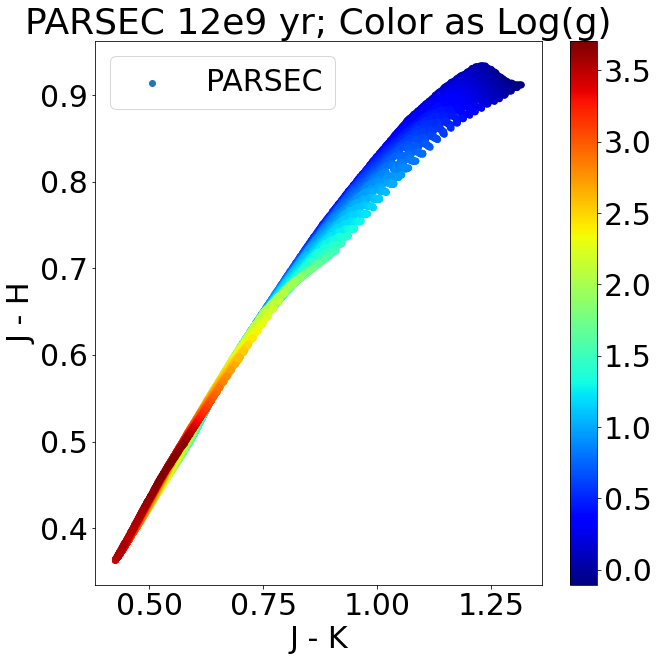

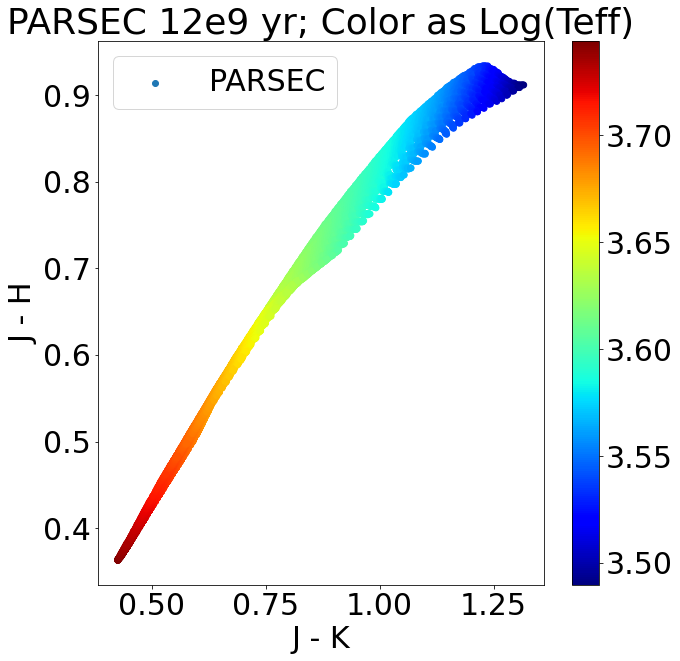

In [47]:
plt.figure(figsize=[10,10])
plt.scatter(parsec12e9['Jmag']-parsec12e9['Ksmag'],parsec12e9['Jmag']-parsec12e9['Hmag'],c=parsec12e9['logg'],
            cmap='jet',label='PARSEC')
plt.legend()
plt.colorbar()
plt.title(r'PARSEC 12e9 yr; Color as Log(g)')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parsec12e9['Jmag']-parsec12e9['Ksmag'],parsec12e9['Jmag']-parsec12e9['Hmag'],c=parsec12e9['logTe'],
            cmap='jet',label='PARSEC')
plt.legend()
plt.colorbar()
plt.title(r'PARSEC 12e9 yr; Color as Log(Teff)')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.show()

In [48]:
ejkak = extinct.cardelli_e12av(leff['J'],leff['K'],3.1)/extinct.cardelli_alav(leff['K'],3.1)

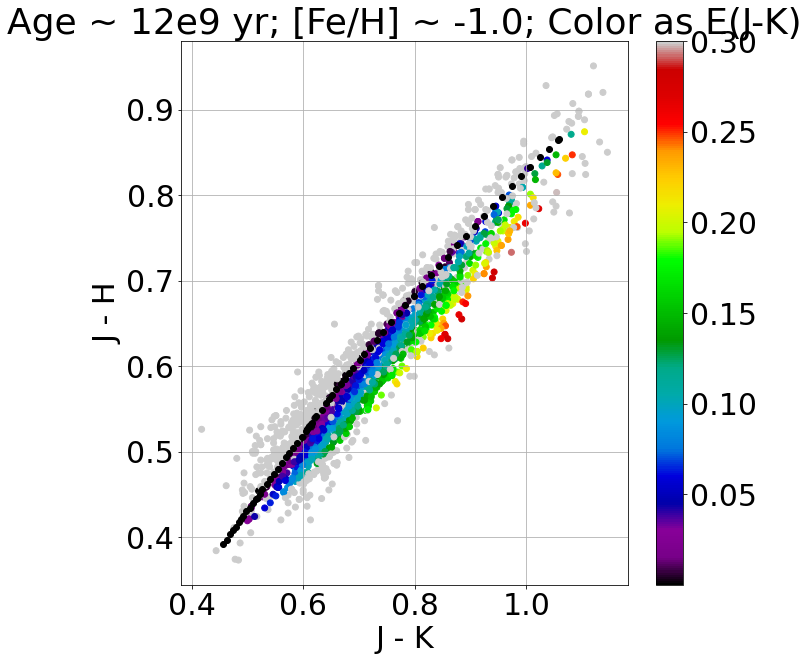

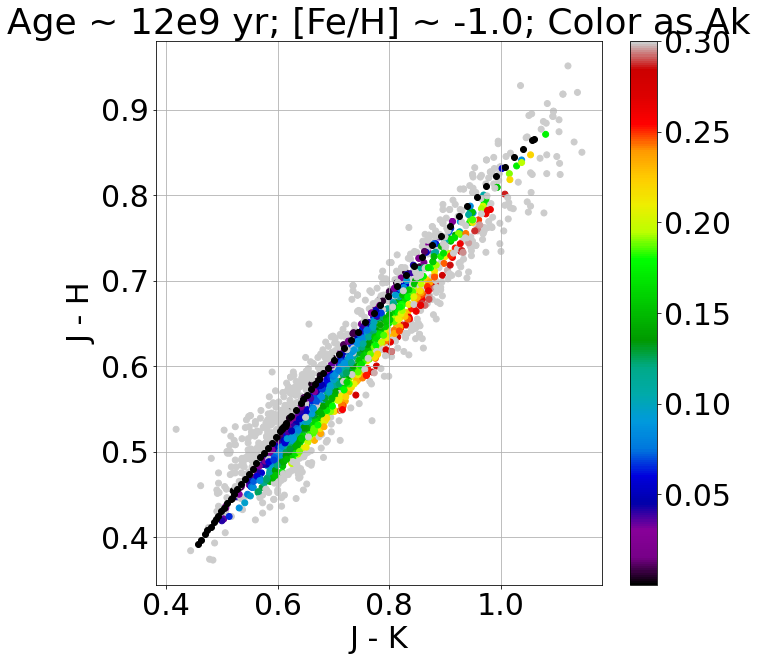

In [59]:
plt.figure(figsize=[10,10])
plt.grid()
plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_1_0],
            zorder=2,c='k')
plt.scatter(gcs['J']-gcs['K'],gcs['J']-gcs['H'],c=(gcs['J']-gcs['K']-jk_int)*(ejkak**-1),zorder=1,vmax=0.3,
            cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -1.0; Color as E(J-K)')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.savefig('physical_ejk.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.grid()
plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_1_0],
            zorder=2,c='k')
plt.scatter(gcs['J']-gcs['K'],gcs['J']-gcs['H'],c=(gcs['J']-gcs['K']-jk_int),zorder=1,vmax=0.3,
            cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -1.0; Color as Ak')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.savefig('physical_ak.pdf',bbox_inches='tight')
plt.show()

In [50]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    
    Output:
    ------
        value in dat closest to val
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

def parsec_locus_jhjk_alt(x0,y0,cer,feh,age,isochrones):
    '''
    Find the where a star would be located on the stellar locus in (J - K)-(J - H) color space.
    (J - K) is the abscissa and (J - H) is the ordinate.
    
    Inputs:
    ------
        x0: J - K color of star
        y0: J - H color of star
        cer: color excess ratio [E(J - H)/E(J - K)]
        feh: metallicity of star
        age: age in Gyr
        isochrones: set of parsec isochrones
    
    Outputs:
    -------
        jk_cross: J - K of intersection point
        jh_cross: J - H of intersection point
    '''
    single = isochrones[np.where((isochrones['logAge']==closest(np.log10(age*10**9),isochrones['logAge']))&
                             (isochrones['MH']==closest(feh,isochrones['MH'])))]
    xs = (single['Jmag'] - single['Ksmag'])
    ys = (single['Jmag'] - single['Hmag'])
    
    bins = np.arange(np.min(xs),np.max(xs),0.005)
    binned_color = binned_statistic(xs, ys, statistic='median', bins=bins).statistic
    
    fin = np.where((np.isfinite(bins[:-1])==True)&(np.isfinite(binned_color)==True))
    
    bins = bins[:-1][fin]
    binned_color = binned_color[fin]
    
    # Interpolate Isochrone
    spline = InterpolatedUnivariateSpline(bins,binned_color,ext=0)
    y_spl = spline(bins)
    
    # Find the crossing point
#     if y0 - spline(x0)>0:
#         # what to do if star is above isochrone in color-color space
#         return np.squeeze([-9999.0,-9999.0])

#     else:
    # Find roots in difference between the ccline and isochrone
    func = y_spl - ccline(bins,cer,x0,y0)
    func_spl = InterpolatedUnivariateSpline(bins,func,ext=0)
    jk_cross = func_spl.roots()
    jh_cross = spline(jk_cross)
        
    if len(jk_cross)==0:
            # If cross12 is empty 
        return np.squeeze([-9999.0,-9999.0])
        
    else:
            # Return Cartesian coordinates of crossing point in color-color space
        return np.squeeze(list(zip(jk_cross, jh_cross)))

def parsec_locus_alt(x0,y0,mag1,mag2,mag3,mag4,cer,feh,age,parsec):
    '''
    Find the where a star would be located on the stellar locus in (1 - 2)-(3 - 4) color space.
    (1 - 2) is the abscissa and (3 - 4) is the ordinate.
    
    Inputs:
    ------
        x0: (1 - 2) color of star off locus
        y0: (3 - 4) color of star off locus
        mag1: [str] first magnitude in (1 - 2) color
        mag2: [str] second magnitude in (1 - 2) color
        mag3: [str] first magnitude in (3 - 4) color
        mag4: [str] second magnitude in (3 - 4) color
        cer: color excess ratio [E(3 - 4)/E(1 - 2)]
        feh: metallicity of star
        age: age in Gyr
        parsec: set of parsec isochrones
    
    Outputs:
    -------
        cross12: (1 - 2) of intersection point
        cross34: (3 - 4) of intersection point
    '''
    
    single = parsec[np.where((parsec['logAge']==closest(np.log10(age*10**9),parsec['logAge']))&
                             (parsec['MH']==closest(feh,parsec['MH'])))]
    xs = (single[mag1] - single[mag2])
    ys = (single[mag3] - single[mag4])
    
    bins = np.arange(np.min(xs),np.max(xs),0.005)
    binned_color = binned_statistic(xs, ys, statistic='median', bins=bins).statistic
    
    fin = np.where((np.isfinite(bins[:-1])==True)&(np.isfinite(binned_color)==True))
    
    bins = bins[:-1][fin]
    binned_color = binned_color[fin]
    
    # Interpolate Isochrone
    spline = InterpolatedUnivariateSpline(bins,binned_color,ext=0)
    y_spl = spline(bins)
    
    # Find the crossing point
#     if y0 - spline(x0)>0:
#         # what to do if star is above isochrone in color-color space
#         return np.squeeze([-9999.0,-9999.0])

#     else:
    # Find roots in difference between the ccline and isochrone
    func = y_spl - ccline(bins,cer,x0,y0)
    func_spl = InterpolatedUnivariateSpline(bins,func,ext=0)
    cross12 = func_spl.roots()
    cross34 = spline(cross12)
        
    if len(cross12)==0:
        # If cross12 is empty 
        return np.squeeze([-9999.0,-9999.0])
        
    else:
        # Return Cartesian coordinates of crossing point in color-color space
        return np.squeeze(list(zip(cross12, cross34)))

In [51]:
cross = []
for i in tqdm_notebook(range(len(gcs))):
    cross.append(parsec_locus_jhjk_alt(gcs['J'][i]-gcs['K'][i],gcs['J'][i]-gcs['H'][i],cerjhjk,gcs['FE_H'][i],
                                         12,parsec12e9))
    
for i in range(len(cross)):
    if np.shape(cross[i])!=(2,):
        cross[i] = np.array([-9999.0,-9999.0])
        
jk_int_alt = []
jh_int_alt = []
for i in range(len(cross)):
    jk_int_alt.append(cross[i][0])
    jh_int_alt.append(cross[i][1])
    
jk_int_alt = np.asarray(jk_int_alt)
jh_int_alt = np.asarray(jh_int_alt)

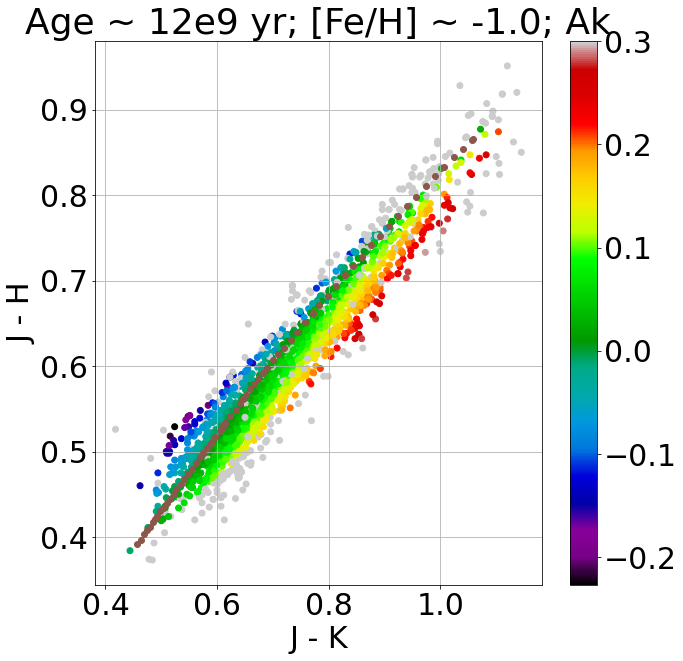

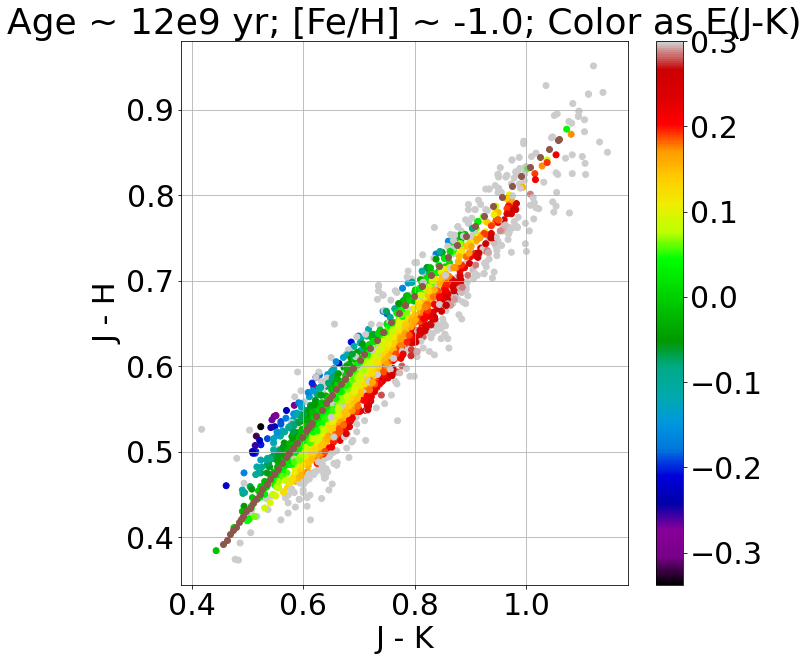

In [96]:
plt.figure(figsize=[10,10])
plt.grid()
plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_1_0],
            zorder=2,c='tab:brown')
plt.scatter(gcs['J']-gcs['K'],gcs['J']-gcs['H'],c=(gcs['J']-gcs['K']-jk_int_alt)*(ejkak**-1),zorder=1,vmax=0.3,
            cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -1.0; Ak')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.savefig('distance_ak.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.grid()
plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_1_0],
            zorder=2,c='tab:brown')
plt.scatter(gcs['J']-gcs['K'],gcs['J']-gcs['H'],c=(gcs['J']-gcs['K']-jk_int_alt),zorder=1,vmax=0.3,
            cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -1.0; Color as E(J-K)')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.savefig('distance_ejk.pdf',bbox_inches='tight')
plt.show()

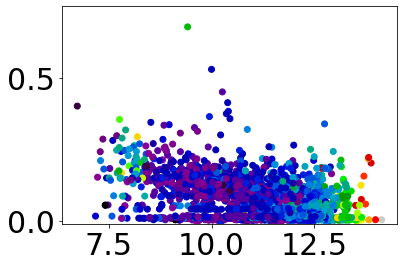

(0.0, 0.06)

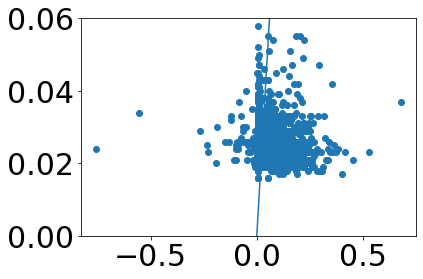

In [121]:
plt.scatter(gcs['K'],gcs['AK_TARG'],c=gcs['K_ERR'],cmap='nipy_spectral')
plt.ylim(bottom=-0.01)
plt.show()

plt.scatter(gcs['AK_TARG'],gcs['K_ERR'])
plt.plot([0.,0.5],[0.,0.5])
plt.ylim(0,0.06)

0.033837847
0.0035545277408066665


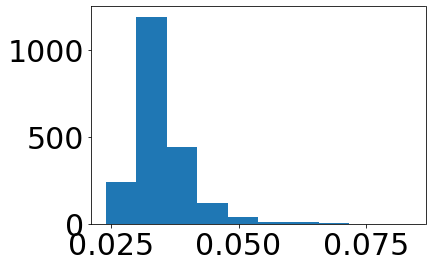

0.022706958879937712
0.0023852741770711674


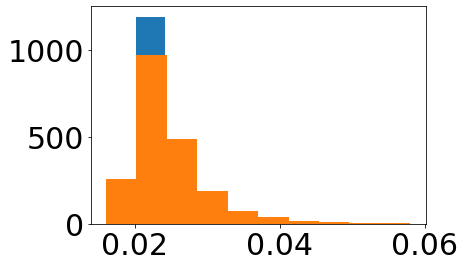

In [109]:
color_err = np.asarray(np.sqrt(gcs['J_ERR']**2+gcs['K_ERR']**2))
print(np.median(color_err))
print(dln.mad(color_err))
plt.hist(color_err)
plt.show()

print(np.median(color_err)/ejkak)
print(dln.mad(color_err/ejkak))
plt.hist(color_err/ejkak)
plt.hist(gcs['K_ERR'])
plt.show()

In [108]:
gcs.columns

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

0.057833925


0.07213514319415283

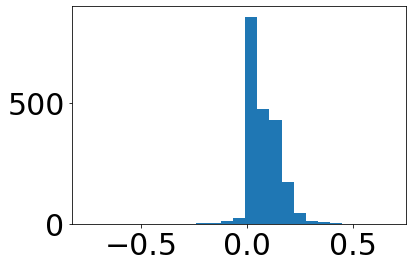

In [53]:
plt.hist(gcs['AK_TARG'],bins=25)
print(np.median(gcs['AK_TARG']))
dln.mad(np.asarray(gcs['AK_TARG']))

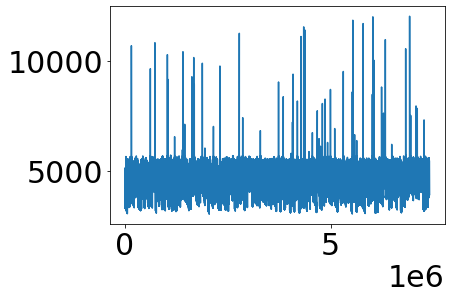

In [54]:
plt.plot(10**massive['logTe'])

In [83]:
### Calculate jk and jh colors for the crossing

jk_cross = []
jh_cross = []
for i in tqdm_notebook(range(len(gcs))):
    jk_distr = []
    jh_distr = []
    for j in range(200):
        jmag = np.random.normal(gcs['J'][i],gcs['J_ERR'][i])
        hmag = np.random.normal(gcs['H'][i],gcs['H_ERR'][i])
        kmag = np.random.normal(gcs['K'][i],gcs['K_ERR'][i])
        feh = np.random.normal(gcs['FE_H'][i],gcs['FE_H_ERR'][i])
        
        locus = parsec_locus_jhjk_alt(jmag-kmag,jmag-hmag,cerjhjk,feh,12,parsec12e9)
        jk_distr.append(locus[0])
        jh_distr.append(locus[1])
        
    jk_cross.append(jk_distr)
    jh_cross.append(jh_distr)
        
### assign -9999.0 to bad values if they still exist
for i in range(len(jk_cross)):
    for j in range(len(jk_cross[i])):
        if np.asarray(jk_cross[i][j]).size > 1:
            jk_cross[i][j] = -9999.0
            
for i in range(len(jh_cross)):
    for j in range(len(jh_cross[i])):
        if np.asarray(jh_cross[i][j]).size > 1:
            jh_cross[i][j] = -9999.0

TypeError: list indices must be integers or slices, not tuple

In [93]:
# Calculate medians and MADs
jk_meds_cln = []
jh_meds_cln = []
jk_devs_cln = []
jh_devs_cln = []

jk_meds = []
jh_meds = []
jk_devs = []
jh_devs = []

for i in range(len(jk_cross)):
    cln = np.where((np.asarray(jk_cross[i])!=-9999.0)&(np.asarray(jh_cross[i])!=-9999.0))
    
    jk_meds_cln.append(np.median(np.asarray(jk_cross[i])[cln]))
    jh_meds_cln.append(np.median(np.asarray(jh_cross[i])[cln]))
    jk_devs_cln.append(dln.mad(np.asarray(jk_cross[i])[cln]))
    jh_devs_cln.append(dln.mad(np.asarray(jh_cross[i])[cln]))
    
    jk_meds.append(np.median(np.asarray(jk_cross[i])))
    jh_meds.append(np.median(np.asarray(jh_cross[i])))
    jk_devs.append(dln.mad(np.asarray(jk_cross[i])))
    jh_devs.append(dln.mad(np.asarray(jh_cross[i])))

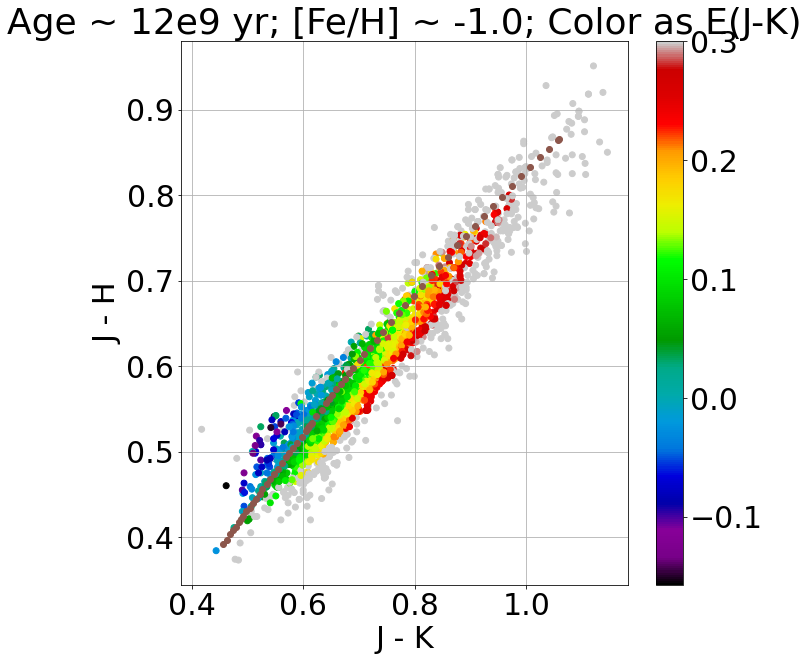

In [97]:
plt.figure(figsize=[10,10])
plt.grid()
plt.scatter((parsec12e9['Jmag']-parsec12e9['Ksmag'])[s12_1_0],(parsec12e9['Jmag']-parsec12e9['Hmag'])[s12_1_0],
            zorder=2,c='tab:brown')
plt.scatter(gcs['J']-gcs['K'],gcs['J']-gcs['H'],c=(gcs['J']-gcs['K']-jk_meds),zorder=1,vmax=0.3,
            cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Age ~ 12e9 yr; [Fe/H] ~ -1.0; Color as E(J-K)')
plt.xlabel(r'J - K')
plt.ylabel(r'J - H')
plt.show()

In [73]:
jk_distr[0].size

1